set-up

In [21]:
# ============================================================================
# Part 1: Imports, Config, Data Pipeline, Warmup Loss (L1 + 0.5·SSIM + 0.1·Edge)
# ============================================================================

import os, glob, math, warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

print(f"TensorFlow: {tf.__version__}")
assert tuple(map(int, tf.__version__.split('.')[:2])) >= (2, 9), "Require TF >= 2.9"

# -------------------------
# Config (1024 + 32x32 latent to keep ~1000× at 8-bit)
# -------------------------
DATA_DIR      = '/content/drive/MyDrive/h01_cutouts_4nm'   # 修改为你的数据目录
IMAGE_SIZE    = 1024                                       # 我们在 1024 原生分辨率训练
NUM_IMAGES    = 3000                                       # 使用多少张图（可调）
BATCH_SIZE    = 8                                          # 1024 建议批量小一点
VAL_RATIO     = 0.10
TRAIN_RATIO   = 0.90
BACKGROUND    = 'white'                                    # RGBA 合成底色: 'white' or 'black'

# Warmup (只训重建) 超参数
EPOCHS_WARMUP = 100
LR_WARMUP     = 2e-4

# 复现实验（可选）
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism = False

# -------------------------
# Drive (Colab)
# -------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print("Colab drive not mounted (running locally or already mounted).", e)

# -------------------------
# Gather file list
# -------------------------
print(f"\n📂 Loading data from {DATA_DIR} ...")
all_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.png')))
if len(all_paths) == 0:
    all_paths = sorted(glob.glob(os.path.join(DATA_DIR, '**/*.png'), recursive=True))
if len(all_paths) == 0:
    raise FileNotFoundError(f"No PNG images found under {DATA_DIR}")

image_paths = all_paths[:NUM_IMAGES]
print(f"✅ Found {len(all_paths)} total PNGs; Using: {len(image_paths)}")

# Probe original size (optional log)
try:
    with Image.open(image_paths[0]) as sample:
        orig_w, orig_h = sample.size
        print(f"   Original size: {orig_w}×{orig_h}  ->  Target: {IMAGE_SIZE}×{IMAGE_SIZE}")
except Exception as e:
    print("   (Skip probing original size)", e)

# -------------------------
# Loader: RGBA-safe → grayscale, bicubic+antialias, normalize to [-0.5, 0.5]
# -------------------------
def load_image(path):
    s = tf.io.read_file(path)
    x = tf.image.decode_png(s, channels=0)           # keep original channels (L/LA/RGB/RGBA)
    x = tf.cast(x, tf.float32) / 255.0               # [0,1]

    c = tf.shape(x)[-1]

    def to_gray_from_rgb(rgb):
        return tf.image.rgb_to_grayscale(rgb)

    def handle_rgba(rgba):
        rgb, a = rgba[..., :3], rgba[..., -1:]
        bg = tf.ones_like(rgb) if BACKGROUND == 'white' else tf.zeros_like(rgb)
        rgb_premul = rgb * a + bg * (1.0 - a)        # alpha composition
        return to_gray_from_rgb(rgb_premul)

    # TF 2.19: tf.case needs list of (predicate, fn), not dict
    gray = tf.case(
        [
            (tf.equal(c, 1), lambda: x),                     # L
            (tf.equal(c, 2), lambda: x[..., :1]),            # LA -> take L
            (tf.equal(c, 3), lambda: to_gray_from_rgb(x)),   # RGB
            (tf.equal(c, 4), lambda: handle_rgba(x)),        # RGBA
        ],
        default=lambda: to_gray_from_rgb(x[..., :3]),
        exclusive=True
    )

    gray = tf.image.resize(gray, [IMAGE_SIZE, IMAGE_SIZE],
                           method='bicubic', antialias=True)
    return gray - 0.5                                      # [-0.5, 0.5]

# -------------------------
# Split
# -------------------------
n_total = len(image_paths)
n_train = int(TRAIN_RATIO * n_total)
n_val   = int(VAL_RATIO   * n_total)
train_paths = image_paths[:n_train]
val_paths   = image_paths[n_train:n_train+n_val]
print(f"\n📊 Split -> Train: {len(train_paths)} | Val: {len(val_paths)} | Unused: {n_total - n_train - n_val}")

# -------------------------
# tf.data pipelines
# -------------------------
AUTO = tf.data.AUTOTUNE

train_ds = (tf.data.Dataset.from_tensor_slices(train_paths)
            .shuffle(min(20000, len(train_paths)), seed=SEED, reshuffle_each_iteration=True)
            .map(load_image, num_parallel_calls=AUTO)
            .map(lambda x: (x, x), num_parallel_calls=AUTO)   # autoencoder: input = target
            .batch(BATCH_SIZE, drop_remainder=False)
            .prefetch(AUTO))

val_ds = (tf.data.Dataset.from_tensor_slices(val_paths)
          .map(load_image, num_parallel_calls=AUTO)
          .map(lambda x: (x, x), num_parallel_calls=AUTO)
          .batch(BATCH_SIZE, drop_remainder=False)
          .prefetch(AUTO))

print("✅ Datasets ready!")

# -------------------------
# Warmup loss: L1 + 0.5·SSIM + 0.1·Edge
#   - inputs in [-0.5,0.5]; SSIM expects [0,1] so we shift by +0.5
#   - Edge uses Sobel gradient magnitude
# -------------------------
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def ssim_loss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(
        tf.image.ssim(y_true + 0.5, y_pred + 0.5, max_val=1.0)
    )

def edge_loss(y_true, y_pred):
    def grad_mag(x):
        g = tf.image.sobel_edges(x)                   # [B,H,W,1,2] -> (dx, dy)
        return tf.sqrt(1e-6 + tf.reduce_sum(g**2, axis=-1))   # [B,H,W,1]
    return tf.reduce_mean(tf.abs(grad_mag(y_true) - grad_mag(y_pred)))

def warmup_loss(y_true, y_pred):
    l1   = l1_loss(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    edge = edge_loss(y_true, y_pred)
    return l1 + 0.5 * ssim + 0.10 * edge

# 可选：监控指标
def psnr_metric(y_true, y_pred):   # expects [0,1]
    return tf.reduce_mean(tf.image.psnr(y_true + 0.5, y_pred + 0.5, max_val=1.0))

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true + 0.5, y_pred + 0.5, max_val=1.0))

# -------------------------
# Warmup compile helper (在“下一部分”给出模型后调用)
# -------------------------
def compile_warmup(model):
    opt = tf.keras.optimizers.AdamW(learning_rate=LR_WARMUP, weight_decay=1e-4)
    model.compile(optimizer=opt, loss=warmup_loss, metrics=[psnr_metric, ssim_metric])
    return model
# 使用方式（等你拿到模型后再运行）：
# compile_warmup(model)
# history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_WARMUP, verbose=1)


TensorFlow: 2.19.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📂 Loading data from /content/drive/MyDrive/h01_cutouts_4nm ...
✅ Found 3001 total PNGs; Using: 3000
   Original size: 1024×1024  ->  Target: 1024×1024

📊 Split -> Train: 2700 | Val: 300 | Unused: 0
✅ Datasets ready!


Warm-up Training

test - top-only


In [23]:
# ==============================================================
# Stage-TopOnly (Single-level VQ-VAE, EMA codebook)
# - Latent = 32x32
# - 仅 Top 路径：Enc(1024->32) -> VQ -> Dec(32->1024)
# - 自动保存最佳 (val_loss / val_ssim_metric)，载入最佳并导出 bundle
# 依赖：已运行 Part 1，已有 train_ds / val_ds / warmup_loss / LR_WARMUP 等
# ==============================================================

import os, time, json, math
import numpy as np
import tensorflow as tf
from PIL import Image

# -----------------------------
# (A) Residual helpers
# -----------------------------
if 'residual_stack' not in globals():
    def residual_block(x, filters):
        skip = x
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters//2, 3, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters, 1, padding='same')(x)
        return tf.keras.layers.Add()([skip, x])

    def residual_stack(x, filters, num_blocks=2):
        for _ in range(num_blocks):
            x = residual_block(x, filters)
        return tf.keras.layers.ReLU()(x)

# -----------------------------
# (B) EMA VectorQuantizer (与之前一致)
# -----------------------------
class VectorQuantizerEMA(tf.keras.layers.Layer):
    def __init__(self, num_embeddings, embedding_dim,
                 commitment_cost=0.25, decay=0.99, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.num_embeddings = int(num_embeddings)
        self.embedding_dim = int(embedding_dim)
        self.commitment_cost = float(commitment_cost)
        self.decay = float(decay)
        self.epsilon = float(epsilon)
        self._perplexity = tf.keras.metrics.Mean(name=f'{self.name}_perplexity')

    @property
    def metrics(self):
        return [self._perplexity]

    def build(self, input_shape):
        self.embeddings = self.add_weight(
            name='embeddings',
            shape=(self.embedding_dim, self.num_embeddings),
            initializer=tf.keras.initializers.RandomUniform(-1.0/self.num_embeddings, 1.0/self.num_embeddings),
            trainable=False
        )
        self.ema_cluster_size = self.add_weight(
            name='ema_cluster_size',
            shape=(self.num_embeddings,),
            initializer='zeros',
            trainable=False
        )
        self.ema_dw = self.add_weight(
            name='ema_dw',
            shape=(self.embedding_dim, self.num_embeddings),
            initializer='zeros',
            trainable=False
        )

    def call(self, inputs, training=None):
        shp  = tf.shape(inputs)                              # [B,H,W,C]
        flat = tf.reshape(inputs, [-1, self.embedding_dim])  # [N,C]

        dists = (tf.reduce_sum(flat**2, axis=1, keepdims=True)
                 - 2.0 * tf.matmul(flat, self.embeddings)
                 + tf.reduce_sum(self.embeddings**2, axis=0, keepdims=True))  # [N,K]
        idx  = tf.argmax(-dists, axis=1)                     # [N]
        one  = tf.one_hot(idx, self.num_embeddings, dtype=flat.dtype)  # [N,K]
        quant = tf.matmul(one, tf.transpose(self.embeddings))          # [N,C]
        quant = tf.reshape(quant, shp)                                   # [B,H,W,C]

        def _ema_update():
            cluster_size = tf.reduce_sum(one, axis=0)
            dw = tf.matmul(tf.transpose(flat), one)
            ema_cs = self.ema_cluster_size * self.decay + cluster_size * (1.0 - self.decay)
            ema_dw = self.ema_dw * self.decay + dw * (1.0 - self.decay)
            n = tf.reduce_sum(ema_cs)
            smoothed_cs = (ema_cs + self.epsilon) / (n + self.num_embeddings * self.epsilon) * n
            new_embed = ema_dw / tf.expand_dims(smoothed_cs, 0)
            self.ema_cluster_size.assign(ema_cs)
            self.ema_dw.assign(ema_dw)
            self.embeddings.assign(new_embed)
            return 0.0

        if training is None:
            training = tf.keras.backend.learning_phase()
        tf.cond(tf.cast(training, tf.bool), _ema_update, lambda: 0.0)

        # commitment loss
        e_loss = tf.reduce_mean((tf.stop_gradient(quant) - inputs)**2)
        self.add_loss(self.commitment_cost * e_loss)

        # perplexity
        avg_p = tf.reduce_mean(one, axis=0)
        perp  = tf.exp(-tf.reduce_sum(avg_p * tf.math.log(avg_p + 1e-10)))
        self._perplexity.update_state(perp)

        # straight-through
        quant = inputs + tf.stop_gradient(quant - inputs)
        return quant

# -----------------------------
# (C) Hyperparams（仅保留 Top）
# -----------------------------
IMAGE_SIZE      = int(globals().get('IMAGE_SIZE', 1024))
TOP_GRID        = int(globals().get('TOP_GRID', 32))

NUM_HIDDENS_TOP   = int(globals().get('NUM_HIDDENS_TOP', 128))
EMBEDDING_DIM_TOP = int(globals().get('EMBEDDING_DIM_TOP', 96))
NUM_EMBEDDINGS_TOP= int(globals().get('NUM_EMBEDDINGS_TOP', 256))
COMMITMENT_COST_TOP = float(globals().get('COMMITMENT_COST_TOP', 1.0))

# -----------------------------
# (D) Blocks: Enc(1024->32) / Dec(32->1024)
# -----------------------------
def build_encoder_to_top(img_size, top_grid, num_hiddens):
    """直接从图像下采样到 32x32。1024->32 需要 5 次 stride=2。"""
    assert (img_size % top_grid) == 0
    n_downs = int(math.log2(img_size // top_grid))  # 1024->32 = 5
    inputs = tf.keras.Input(shape=(img_size, img_size, 1))
    x = inputs
    chans = [64, 128, 128, 128, num_hiddens][:n_downs]
    for c in chans:
        x = tf.keras.layers.Conv2D(c, 4, strides=2, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
    x = residual_stack(x, num_hiddens, num_blocks=2)
    return tf.keras.Model(inputs, x, name=f'encoder_to_top_{top_grid}')

def build_decoder_top_to_image(img_size, top_grid, in_ch):
    """从 32x32 直接上采样到 1024。需要 5 次 upsample。"""
    assert (img_size % top_grid) == 0
    n_ups = int(math.log2(img_size // top_grid))    # 32->1024 = 5
    inputs = tf.keras.Input(shape=(top_grid, top_grid, in_ch))
    x = inputs
    ups_ch = [256, 128, 128, 64, 32][:n_ups]
    for c in ups_ch:
        x = tf.keras.layers.Conv2DTranspose(c, 4, strides=2, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
    out = tf.keras.layers.Conv2D(1, 3, padding='same')(x)
    return tf.keras.Model(inputs, out, name=f'decoder_top_{top_grid}_to_{IMAGE_SIZE}')

# -----------------------------
# (E) Assemble Top-only model
# -----------------------------
enc_top  = build_encoder_to_top(IMAGE_SIZE, TOP_GRID, NUM_HIDDENS_TOP)

pre_vq_top   = tf.keras.layers.Conv2D(EMBEDDING_DIM_TOP, 1, name='pre_vq_top')
vq_top       = VectorQuantizerEMA(NUM_EMBEDDINGS_TOP, EMBEDDING_DIM_TOP,
                                  commitment_cost=COMMITMENT_COST_TOP, decay=0.99, epsilon=1e-5, name='vq_top')
post_vq_top  = tf.keras.layers.Conv2D(NUM_HIDDENS_TOP, 1, name='post_vq_top')

dec_top = build_decoder_top_to_image(IMAGE_SIZE, TOP_GRID, in_ch=NUM_HIDDENS_TOP)

class VQTopOnlyEMA(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_top   = enc_top
        self.pre_vq_top= pre_vq_top
        self.vq_top    = vq_top
        self.post_vq_top = post_vq_top
        self.dec_top   = dec_top
        self.norm_t    = tf.keras.layers.LayerNormalization(axis=-1)
        self.drop_t    = tf.keras.layers.SpatialDropout2D(0.1)  # 轻一点的 dropout，防过拟合

    def call(self, x, training=None):
        ht  = self.enc_top(x)                   # [B,32,32,Ht]
        zt  = self.pre_vq_top(ht)               # [B,32,32,Ct]
        ztq = self.vq_top(zt, training=training)
        ztq = self.post_vq_top(ztq)             # [B,32,32,Ht]
        ztq = self.norm_t(ztq)
        ztq = self.drop_t(ztq, training=training)
        y   = self.dec_top(ztq)                 # [B,1024,1024,1]
        return y

model = VQTopOnlyEMA()

# -----------------------------
# (F) Compile（沿用你 Part 1 的 warmup_loss/metrics/优化器策略）
# -----------------------------
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true + 0.5, y_pred + 0.5, max_val=1.0))

def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true + 0.5, y_pred + 0.5, max_val=1.0))

def compile_warmup(m, lr=None, wd=1e-4):
    if lr is None:
        lr = float(globals().get('LR_WARMUP', 2e-4))
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd, beta_1=0.9, beta_2=0.95)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.95)
    loss_fn = globals().get('warmup_loss', 'mae')
    m.compile(optimizer=opt, loss=loss_fn, metrics=[psnr_metric, ssim_metric])

compile_warmup(model)

# -----------------------------
# (G) Callbacks & Export
# -----------------------------

def make_top_callbacks(out_dir,
                       monitor_primary="val_ssim_metric",
                       monitor_secondary="val_loss"):
    os.makedirs(out_dir, exist_ok=True)
    return [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(out_dir, "top_best_by_ssim.weights.h5"),
            save_weights_only=True, save_best_only=True,
            monitor=monitor_primary, mode="max", verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(out_dir, "top_best_by_vloss.weights.h5"),
            save_weights_only=True, save_best_only=True,
            monitor=monitor_secondary, mode="min", verbose=1),
        tf.keras.callbacks.CSVLogger(os.path.join(out_dir, "top_log.csv")),
        tf.keras.callbacks.TensorBoard(log_dir=os.path.join(out_dir, "tb_top")),
    ]


def _to_uint8(x):
    x = np.clip(x, 0.0, 1.0)
    return (x * 255.0 + 0.5).astype(np.uint8)

def save_png01(img01, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(_to_uint8(img01)).save(path, 'PNG')

def _top_manifest_dict():
    return {
        "IMAGE_SIZE": IMAGE_SIZE,
        "TOP_GRID": TOP_GRID,
        "NUM_EMBEDDINGS_TOP": NUM_EMBEDDINGS_TOP,
        "EMBEDDING_DIM_TOP": EMBEDDING_DIM_TOP,
        "COMMITMENT_COST_TOP": COMMITMENT_COST_TOP,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }

def export_top_bundle(model, out_root="/content/drive/MyDrive/vqvae_toponly_runs",
                      run_dir=None, history=None, take_val=1, also_savedmodel=False):
    os.makedirs(out_root, exist_ok=True)
    stamp = time.strftime("%Y%m%d-%H%M%S") if run_dir is None else run_dir
    bundle_dir = os.path.join(out_root, stamp)
    os.makedirs(bundle_dir, exist_ok=True)

    # ensure built
    try:
        _xb = next(iter(train_ds))[0]
        _ = model(_xb[:1], training=False)
    except Exception:
        pass

    # 1) weights
    w_path = os.path.join(bundle_dir, "toponly.weights.h5")
    model.save_weights(w_path)

    # 2) codebook + EMA
    np.save(os.path.join(bundle_dir, "vq_top_emb.npy"), model.vq_top.embeddings.numpy())
    np.save(os.path.join(bundle_dir, "vq_top_ema_cluster_size.npy"), model.vq_top.ema_cluster_size.numpy())
    np.save(os.path.join(bundle_dir, "vq_top_ema_dw.npy"), model.vq_top.ema_dw.numpy())

    # 3) manifest
    with open(os.path.join(bundle_dir, "manifest.json"), "w") as f:
        json.dump(_top_manifest_dict(), f, indent=2)

    # 4) history
    if history is not None and hasattr(history, "history"):
        with open(os.path.join(bundle_dir, "history.json"), "w") as f:
            json.dump(history.history, f, indent=2)

    # 5) sample
    sample_dir = os.path.join(bundle_dir, "samples"); os.makedirs(sample_dir, exist_ok=True)
    taken = 0
    for xb, _ in val_ds.take(take_val):
        yb = model(xb, training=False)
        save_png01((xb.numpy()[0,...,0] + 0.5), os.path.join(sample_dir, f"ae_input_val0.png"))
        save_png01((yb.numpy()[0,...,0] + 0.5), os.path.join(sample_dir, f"ae_recon_val0.png"))
        taken += 1
        if taken >= take_val: break

    # 6) SavedModel（可选）
    if also_savedmodel:
        sm_dir = os.path.join(bundle_dir, "saved_model")
        model.save(sm_dir)

    # 7) latest symlink or marker
    latest = os.path.join(out_root, "latest")
    try:
        if os.path.islink(latest) or os.path.exists(latest):
            os.remove(latest)
        os.symlink(bundle_dir, latest)
    except Exception:
        with open(os.path.join(out_root, "LATEST.txt"), "w") as f:
            f.write(bundle_dir)

    print(f"✅ Top-only bundle saved to: {bundle_dir}")
    return bundle_dir

# -----------------------------
# (H) Bit-accurate compression (Top-only)
# -----------------------------
bits_per_top  = int(math.ceil(math.log2(NUM_EMBEDDINGS_TOP)))   # 256 -> 8
tokens_top    = TOP_GRID * TOP_GRID                             # 1024
latent_bits   = tokens_top * bits_per_top                       # 8192
orig_bits     = IMAGE_SIZE * IMAGE_SIZE * 8                     # 8,388,608
bpp           = latent_bits / (IMAGE_SIZE * IMAGE_SIZE)         # ≈0.0078125
ratio         = orig_bits / latent_bits                         # ≈1024×

print("="*66)
print(f"Bit-accurate compression (Top-only): {ratio:.1f}×  (~{bpp:.5f} bpp)")
print(f" - tokens: top {tokens_top}")
print(f" - bits/token: top {bits_per_top}")
print(f" - commitment(top) = {COMMITMENT_COST_TOP}")
print("="*66)

# -----------------------------
# (I) Train → load best → export
# -----------------------------
EPOCHS_WARMUP = int(globals().get('EPOCHS_WARMUP', 100))

out_root = "/content/drive/MyDrive/vqvae_toponly_runs"
run_stamp = time.strftime("%Y%m%d-%H%M%S")
run_dir   = os.path.join(out_root, run_stamp)

cbs = make_top_callbacks(
    run_dir,
    monitor_primary="val_ssim_metric",
    monitor_secondary="val_loss",
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_WARMUP,
    callbacks=cbs,
    verbose=1
)

best_ckpt = os.path.join(run_dir, "top_best_by_vloss.weights.h5")
model.load_weights(best_ckpt)
print(f"Loaded best weights: {best_ckpt}")

bundle_dir = export_top_bundle(
    model,
    out_root=out_root,
    run_dir=run_stamp,
    history=history,
    also_savedmodel=False
)
print("Exported:", bundle_dir)


Bit-accurate compression (Top-only): 1024.0×  (~0.00781 bpp)
 - tokens: top 1024
 - bits/token: top 8
 - commitment(top) = 1.0
Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.7758 - psnr_metric: 11.1237 - ssim_metric: 0.0293 - vq_top_perplexity: 5.0613
Epoch 1: val_ssim_metric improved from -inf to 0.05121, saving model to /content/drive/MyDrive/vqvae_toponly_runs/20251002-192917/top_best_by_ssim.weights.h5

Epoch 1: val_loss improved from inf to 0.74273, saving model to /content/drive/MyDrive/vqvae_toponly_runs/20251002-192917/top_best_by_vloss.weights.h5
338/338 ━━━━━━━━━━━━━━━━━━━━ 93s 232ms/step - loss: 0.7757 - psnr_metric: 11.1250 - ssim_metric: 0.0293 - vq_top_perplexity: 5.0684 - val_loss: 0.7427 - val_psnr_metric: 12.1810 - val_ssim_metric: 0.0512 - val_vq_top_perplexity: 10.5935
Epoch 2/100
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.7333 - psnr_metric: 12.1669 - ssim_metric: 0.0686 - vq_top_perplexity: 17.1388
Epoch 2: val_ssim_metric improved from 

In [24]:
# =========================== Eval: Top-only 重组第一张测试图 ===========================
import os, glob, json, time, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# 如果你换了会话，这里可手动指定权重再加载：
# model.load_weights("/content/drive/MyDrive/vqvae_toponly_runs/你的时间戳/top_best_by_ssim.weights.h5")

def _to_uint8(x):
    x = np.clip(x, 0.0, 1.0)
    return (x * 255.0 + 0.5).astype(np.uint8)

def save_png01(img01, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(_to_uint8(img01)).save(path, 'PNG')

def find_first_test_image(test_dir):
    paths = sorted(glob.glob(os.path.join(test_dir, '*.png')))
    if len(paths) == 0:
        paths = sorted(glob.glob(os.path.join(test_dir, '**/*.png'), recursive=True))
    if len(paths) == 0:
        raise FileNotFoundError(f"No PNG images found under {test_dir}")
    return paths[0]

# 复用你 Part 1 里的 loader：load_image(path) -> [-0.5,0.5], shape [H,W,1]
def load_img_for_model(path):
    return load_image(path)   # 与训练时完全一致的预处理

def eval_recon_toponly(model, test_path,
                       out_root="/content/drive/MyDrive/vqvae_toponly_eval"):
    os.makedirs(out_root, exist_ok=True)
    stamp = time.strftime("%Y%m%d-%H%M%S")
    out_dir = os.path.join(out_root, stamp)
    os.makedirs(out_dir, exist_ok=True)

    # 读入 + 前向
    x  = load_img_for_model(test_path)          # [H,W,1], [-0.5,0.5]
    x1 = tf.expand_dims(x, 0)                   # [1,H,W,1]
    y1 = model(x1, training=False)              # [1,H,W,1]

    # 回到 [0,1] 以便保存/显示
    x01 = (x1.numpy()[0, ..., 0] + 0.5)
    y01 = (y1.numpy()[0, ..., 0] + 0.5)

    # 指标
    psnr = float(tf.image.psnr(x1 + 0.5, y1 + 0.5, max_val=1.0).numpy().mean())
    ssim = float(tf.image.ssim(x1 + 0.5, y1 + 0.5, max_val=1.0).numpy().mean())

    # 保存原图/重建
    in_path = os.path.join(out_dir, "input.png")
    re_path = os.path.join(out_dir, "recon.png")
    save_png01(x01, in_path)
    save_png01(y01, re_path)

    # 拼图（英文标题，避免中文字体告警）
    fig = plt.figure(figsize=(8, 4), dpi=150)
    ax = plt.subplot(1, 2, 1); ax.imshow(x01, cmap='gray'); ax.set_title("Input"); ax.axis('off')
    ax = plt.subplot(1, 2, 2); ax.imshow(y01, cmap='gray'); ax.set_title("Recon"); ax.axis('off')
    panel_path = os.path.join(out_dir, "panel.png")
    plt.tight_layout(); plt.savefig(panel_path, dpi=150); plt.close(fig)

    # 压缩信息（Top-only）
    bits_per_top = int(math.ceil(math.log2(int(NUM_EMBEDDINGS_TOP))))
    tokens_top   = int(TOP_GRID) * int(TOP_GRID)
    latent_bits  = tokens_top * bits_per_top
    orig_bits    = int(IMAGE_SIZE) * int(IMAGE_SIZE) * 8
    ratio        = orig_bits / latent_bits
    bpp          = latent_bits / (IMAGE_SIZE * IMAGE_SIZE)

    info = {
        "test_path": test_path,
        "psnr": round(psnr, 4),
        "ssim": round(ssim, 6),
        "tokens_top": tokens_top,
        "bits_per_token": bits_per_top,
        "latent_bits": latent_bits,
        "orig_bits": orig_bits,
        "compression_ratio": round(ratio, 2),
        "bpp": bpp
    }
    with open(os.path.join(out_dir, "results.json"), "w") as f:
        json.dump(info, f, indent=2)

    print(f"[Test] {test_path}")
    print(f"[Metrics] PSNR={psnr:.2f}, SSIM={ssim:.4f}")
    print(f"[Bits] tokens={tokens_top}, bits/token={bits_per_top}, "
          f"latent={latent_bits}, orig={orig_bits}, ratio≈{ratio:.1f}× (~{bpp:.5f} bpp)")
    print("✅ Saved:", in_path)
    print("✅ Saved:", re_path)
    print("✅ Saved:", panel_path)
    print("✅ Saved:", os.path.join(out_dir, "results.json"))
    return out_dir

# ---- 运行评测（取 TEST_DIR 第一张 PNG）----
test_img_path = find_first_test_image(TEST_DIR)
_ = eval_recon_toponly(model, test_img_path)


[Test] /content/drive/MyDrive/h01_cutouts_4nm_test/img_slice_3667.png
[Metrics] PSNR=12.73, SSIM=0.1282
[Bits] tokens=1024, bits/token=8, latent=8192, orig=8388608, ratio≈1024.0× (~0.00781 bpp)
✅ Saved: /content/drive/MyDrive/vqvae_toponly_eval/20251002-205159/input.png
✅ Saved: /content/drive/MyDrive/vqvae_toponly_eval/20251002-205159/recon.png
✅ Saved: /content/drive/MyDrive/vqvae_toponly_eval/20251002-205159/panel.png
✅ Saved: /content/drive/MyDrive/vqvae_toponly_eval/20251002-205159/results.json


In [25]:
import csv

def get_test_image_paths(test_dir, n=30):
    paths = sorted(glob.glob(os.path.join(test_dir, '*.png')))
    if len(paths) == 0:
        paths = sorted(glob.glob(os.path.join(test_dir, '**/*.png'), recursive=True))
    if len(paths) == 0:
        raise FileNotFoundError(f"No PNG images found under {test_dir}")
    return paths[:n]

def eval_recon_toponly_many(model, test_paths, out_root="/content/drive/MyDrive/vqvae_toponly_eval", batch_size=2):
    os.makedirs(out_root, exist_ok=True)
    stamp = time.strftime("%Y%m%d-%H%M%S")
    out_dir = os.path.join(out_root, f"{stamp}_batch")
    os.makedirs(out_dir, exist_ok=True)

    # 压缩信息（Top-only，常数）
    bits_per_top = int(math.ceil(math.log2(int(NUM_EMBEDDINGS_TOP))))
    tokens_top   = int(TOP_GRID) * int(TOP_GRID)
    latent_bits  = tokens_top * bits_per_top
    orig_bits    = int(IMAGE_SIZE) * int(IMAGE_SIZE) * 8
    ratio        = orig_bits / latent_bits
    bpp          = latent_bits / (IMAGE_SIZE * IMAGE_SIZE)

    results = []
    for i in range(0, len(test_paths), batch_size):
        chunk = test_paths[i:i+batch_size]
        xs = [load_img_for_model(p) for p in chunk]   # 与训练一致的预处理，[-0.5,0.5]
        x1 = tf.stack(xs, axis=0)                     # [B,H,W,1]
        y1 = model(x1, training=False)

        # 指标（逐样本）
        psnrs = tf.image.psnr(x1 + 0.5, y1 + 0.5, max_val=1.0).numpy()
        ssims = tf.image.ssim(x1 + 0.5, y1 + 0.5, max_val=1.0).numpy()

        x01 = (x1.numpy() + 0.5)[..., 0]  # [B,H,W] in [0,1]
        y01 = (y1.numpy() + 0.5)[..., 0]

        for j, p in enumerate(chunk):
            idx = i + j
            stem = f"{idx:04d}"
            save_png01(x01[j], os.path.join(out_dir, f"{stem}_input.png"))
            save_png01(y01[j], os.path.join(out_dir, f"{stem}_recon.png"))
            results.append({
                "index": idx,
                "test_path": p,
                "psnr": float(psnrs[j]),
                "ssim": float(ssims[j])
            })

    # 汇总与落盘
    avg_psnr = float(np.mean([r["psnr"] for r in results]))
    avg_ssim = float(np.mean([r["ssim"] for r in results]))

    summary = {
        "count": len(test_paths),
        "avg_psnr": round(avg_psnr, 4),
        "avg_ssim": round(avg_ssim, 6),
        "tokens_top": tokens_top,
        "bits_per_token": bits_per_top,
        "latent_bits": latent_bits,
        "orig_bits": orig_bits,
        "compression_ratio": round(ratio, 2),
        "bpp": bpp
    }

    with open(os.path.join(out_dir, "results.json"), "w") as f:
        json.dump({"summary": summary, "results": results}, f, indent=2)

    with open(os.path.join(out_dir, "results.csv"), "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["index", "test_path", "psnr", "ssim"])
        writer.writeheader()
        writer.writerows(results)

    print(f"[BATCH DONE] N={len(test_paths)} | Avg PSNR={avg_psnr:.2f}, Avg SSIM={avg_ssim:.4f}")
    print(f"Saved to: {out_dir}")
    return out_dir

# ---- 运行前 30 张评测 ----
# TEST_DIR = "/content/drive/MyDrive/your_test_dir"
paths_30 = get_test_image_paths(TEST_DIR, n=30)
_ = eval_recon_toponly_many(model, paths_30, batch_size=2)   # 显存紧张就把 batch_size 调小


[BATCH DONE] N=30 | Avg PSNR=12.63, Avg SSIM=0.1242
Saved to: /content/drive/MyDrive/vqvae_toponly_eval/20251002-205236_batch


test end


In [7]:
# ==============================================================
# Stage-1 (Two-level VQ-VAE-2, EMA codebook + LN/Dropout + FiLM)
# - Top = 32x32, Bottom = 64x64
# - Bottom commitment = 0.15 (as requested)
# - 自动保存最佳 (val_loss / val_ssim_metric)，载入最佳并导出 bundle
# ==============================================================

import os, time, json, math
import numpy as np
import tensorflow as tf
from PIL import Image

# -----------------------------
# (A) Residual helpers
# -----------------------------
if 'residual_stack' not in globals():
    def residual_block(x, filters):
        skip = x
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters//2, 3, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters, 1, padding='same')(x)
        return tf.keras.layers.Add()([skip, x])

    def residual_stack(x, filters, num_blocks=2):
        for _ in range(num_blocks):
            x = residual_block(x, filters)
        return tf.keras.layers.ReLU()(x)

# -----------------------------
# (B) EMA VectorQuantizer (VQ-VAE-2)
# -----------------------------
class VectorQuantizerEMA(tf.keras.layers.Layer):
    def __init__(self, num_embeddings, embedding_dim,
                 commitment_cost=0.25, decay=0.99, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.num_embeddings = int(num_embeddings)
        self.embedding_dim = int(embedding_dim)
        self.commitment_cost = float(commitment_cost)
        self.decay = float(decay)
        self.epsilon = float(epsilon)
        self._perplexity = tf.keras.metrics.Mean(name=f'{self.name}_perplexity')

    @property
    def metrics(self):
        return [self._perplexity]

    def build(self, input_shape):
        self.embeddings = self.add_weight(
            name='embeddings',
            shape=(self.embedding_dim, self.num_embeddings),
            initializer=tf.keras.initializers.RandomUniform(-1.0/self.num_embeddings, 1.0/self.num_embeddings),
            trainable=False
        )
        self.ema_cluster_size = self.add_weight(
            name='ema_cluster_size',
            shape=(self.num_embeddings,),
            initializer='zeros',
            trainable=False
        )
        self.ema_dw = self.add_weight(
            name='ema_dw',
            shape=(self.embedding_dim, self.num_embeddings),
            initializer='zeros',
            trainable=False
        )

    def call(self, inputs, training=None):
        shp  = tf.shape(inputs)                              # [B,H,W,C]
        flat = tf.reshape(inputs, [-1, self.embedding_dim])  # [N,C]

        # NN lookup via expanded L2
        dists = (tf.reduce_sum(flat**2, axis=1, keepdims=True)
                 - 2.0 * tf.matmul(flat, self.embeddings)
                 + tf.reduce_sum(self.embeddings**2, axis=0, keepdims=True))  # [N,K]
        idx  = tf.argmax(-dists, axis=1)                     # [N]
        one  = tf.one_hot(idx, self.num_embeddings, dtype=flat.dtype)  # [N,K]
        quant = tf.matmul(one, tf.transpose(self.embeddings))          # [N,C]
        quant = tf.reshape(quant, shp)                                   # [B,H,W,C]

        # EMA updates (training only)
        def _ema_update():
            cluster_size = tf.reduce_sum(one, axis=0)                  # [K]
            dw = tf.matmul(tf.transpose(flat), one)                    # [C,K]
            ema_cs = self.ema_cluster_size * self.decay + cluster_size * (1.0 - self.decay)
            ema_dw = self.ema_dw * self.decay + dw * (1.0 - self.decay)
            n = tf.reduce_sum(ema_cs)
            smoothed_cs = (ema_cs + self.epsilon) / (n + self.num_embeddings * self.epsilon) * n
            new_embed = ema_dw / tf.expand_dims(smoothed_cs, 0)        # [C,K]
            self.ema_cluster_size.assign(ema_cs)
            self.ema_dw.assign(ema_dw)
            self.embeddings.assign(new_embed)
            return 0.0

        if training is None:
            training = tf.keras.backend.learning_phase()
        tf.cond(tf.cast(training, tf.bool), _ema_update, lambda: 0.0)

        # only commitment loss
        e_loss = tf.reduce_mean((tf.stop_gradient(quant) - inputs)**2)
        self.add_loss(self.commitment_cost * e_loss)

        # perplexity
        avg_p = tf.reduce_mean(one, axis=0)
        perp  = tf.exp(-tf.reduce_sum(avg_p * tf.math.log(avg_p + 1e-10)))
        self._perplexity.update_state(perp)

        # straight-through
        quant = inputs + tf.stop_gradient(quant - inputs)
        return quant

# -----------------------------
# (C) Hyperparams (read/override from globals when present)
# -----------------------------
IMAGE_SIZE         = int(globals().get('IMAGE_SIZE', 1024))
TOP_GRID           = int(globals().get('TOP_GRID', 32))
BOTTOM_GRID        = int(globals().get('BOTTOM_GRID', 64))
NUM_HIDDENS_TOP    = int(globals().get('NUM_HIDDENS_TOP', 128))
NUM_HIDDENS_BOTTOM = int(globals().get('NUM_HIDDENS_BOTTOM', 128))

EMBEDDING_DIM_TOP     = int(globals().get('EMBEDDING_DIM_TOP', 96))
EMBEDDING_DIM_BOTTOM  = int(globals().get('EMBEDDING_DIM_BOTTOM', 96))
NUM_EMBEDDINGS_TOP    = int(globals().get('NUM_EMBEDDINGS_TOP', 256))
NUM_EMBEDDINGS_BOTTOM = int(globals().get('NUM_EMBEDDINGS_BOTTOM', 256))

COMMITMENT_COST_TOP    = float(globals().get('COMMITMENT_COST_TOP', 1.0))
COMMITMENT_COST_BOTTOM = float(globals().get('COMMITMENT_COST_BOTTOM', 0.15))   # <—— 你要的 0.15
# --- Hyperparams ---
COMMITMENT_COST_TOP    = float(globals().get('COMMITMENT_COST_TOP', 1.0))
# 强制 0.15：不要再从 globals 读取
COMMITMENT_COST_BOTTOM = 0.15


# -----------------------------
# (D) Building blocks
# -----------------------------
def build_encoder_bottom(img_size, bottom_grid, num_hiddens):
    assert (img_size % bottom_grid) == 0
    n_downs = int(math.log2(img_size // bottom_grid))  # 1024->64 = 4
    inputs = tf.keras.Input(shape=(img_size, img_size, 1))
    x = inputs
    chans = [64, 128, 128, num_hiddens][:n_downs]
    for c in chans:
        x = tf.keras.layers.Conv2D(c, 4, strides=2, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
    x = residual_stack(x, num_hiddens, num_blocks=2)
    return tf.keras.Model(inputs, x, name=f'encoder_bottom_{bottom_grid}')

def build_encoder_top_from_bottom(bottom_grid, top_grid, in_ch, out_ch):
    assert (bottom_grid % top_grid) == 0
    n_downs = int(math.log2(bottom_grid // top_grid))  # 64->32 = 1
    inputs = tf.keras.Input(shape=(bottom_grid, bottom_grid, in_ch))
    x = inputs
    for _ in range(n_downs):
        x = tf.keras.layers.Conv2D(out_ch, 4, strides=2, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
    x = residual_stack(x, out_ch, num_blocks=2)
    return tf.keras.Model(inputs, x, name=f'encoder_top_{top_grid}')

def build_top_to_bottom_upsampler(top_grid, bottom_grid, in_ch, out_ch):
    assert (bottom_grid % top_grid) == 0
    n_ups = int(math.log2(bottom_grid // top_grid))     # 32->64 = 1
    inputs = tf.keras.Input(shape=(top_grid, top_grid, in_ch))
    x = inputs
    for _ in range(n_ups):
        x = tf.keras.layers.Conv2DTranspose(out_ch, 4, strides=2, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
    return tf.keras.Model(inputs, x, name=f'top_upsampler_{top_grid}_to_{bottom_grid}')

def build_decoder_bottom_to_image(img_size, bottom_grid, in_ch):
    assert (img_size % bottom_grid) == 0
    n_ups = int(math.log2(img_size // bottom_grid))    # 64->1024 = 4
    inputs = tf.keras.Input(shape=(bottom_grid, bottom_grid, in_ch))
    x = inputs
    ups_ch = [256, 128, 128, 64][:n_ups]
    for c in ups_ch:
        x = tf.keras.layers.Conv2DTranspose(c, 4, strides=2, padding='same')(x)
        x = tf.keras.layers.ReLU()(x)
    out = tf.keras.layers.Conv2D(1, 3, padding='same')(x)
    return tf.keras.Model(inputs, out, name=f'decoder_bottom_{bottom_grid}_to_{IMAGE_SIZE}')

# -----------------------------
# (E) Assemble Stage-1 model
# -----------------------------
enc_bottom = build_encoder_bottom(IMAGE_SIZE, BOTTOM_GRID, NUM_HIDDENS_BOTTOM)
enc_top    = build_encoder_top_from_bottom(BOTTOM_GRID, TOP_GRID, NUM_HIDDENS_BOTTOM, NUM_HIDDENS_TOP)

pre_vq_top     = tf.keras.layers.Conv2D(EMBEDDING_DIM_TOP, 1, name='pre_vq_top')
vq_top         = VectorQuantizerEMA(NUM_EMBEDDINGS_TOP, EMBEDDING_DIM_TOP,
                                    commitment_cost=COMMITMENT_COST_TOP, decay=0.99, epsilon=1e-5, name='vq_top')
post_vq_top    = tf.keras.layers.Conv2D(NUM_HIDDENS_TOP, 1, name='post_vq_top')

pre_vq_bottom  = tf.keras.layers.Conv2D(EMBEDDING_DIM_BOTTOM, 1, name='pre_vq_bottom')
vq_bottom      = VectorQuantizerEMA(NUM_EMBEDDINGS_BOTTOM, EMBEDDING_DIM_BOTTOM,
                                    commitment_cost=COMMITMENT_COST_BOTTOM, decay=0.99, epsilon=1e-5, name='vq_bottom')
post_vq_bottom = tf.keras.layers.Conv2D(NUM_HIDDENS_BOTTOM, 1, name='post_vq_bottom')

top_up   = build_top_to_bottom_upsampler(TOP_GRID, BOTTOM_GRID, NUM_HIDDENS_TOP, NUM_HIDDENS_BOTTOM)
dec_bot  = build_decoder_bottom_to_image(IMAGE_SIZE, BOTTOM_GRID, in_ch=NUM_HIDDENS_BOTTOM * 2)

class VQTwoLevelEMA(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_bottom = enc_bottom
        self.enc_top    = enc_top
        self.pre_vq_top = pre_vq_top
        self.vq_top     = vq_top
        self.post_vq_top= post_vq_top
        self.pre_vq_bottom  = pre_vq_bottom
        self.vq_bottom      = vq_bottom
        self.post_vq_bottom = post_vq_bottom
        self.top_up   = top_up
        self.dec_bottom = dec_bot
        # info balancing
        self.norm_b = tf.keras.layers.LayerNormalization(axis=-1)
        self.norm_t = tf.keras.layers.LayerNormalization(axis=-1)
        self.drop_b = tf.keras.layers.SpatialDropout2D(0.3)  # training only
        # FiLM
        self.film_gamma = tf.keras.layers.Conv2D(NUM_HIDDENS_BOTTOM, 1)
        self.film_beta  = tf.keras.layers.Conv2D(NUM_HIDDENS_BOTTOM, 1)

    def call(self, x, training=None):
        hb  = self.enc_bottom(x)                 # [B,64,64,Hb]
        zb  = self.pre_vq_bottom(hb)             # [B,64,64,Cb]
        zbq = self.vq_bottom(zb, training=training)
        zbq = self.post_vq_bottom(zbq)           # [B,64,64,Hb]

        ht  = self.enc_top(hb)                   # [B,32,32,Ht]
        zt  = self.pre_vq_top(ht)                # [B,32,32,Ct]
        ztq = self.vq_top(zt, training=training)
        ztq = self.post_vq_top(ztq)              # [B,32,32,Ht]
        t_up= self.top_up(ztq)                   # [B,64,64,Hb]

        zbq = self.norm_b(zbq)
        t_up= self.norm_t(t_up)
        zbq = self.drop_b(zbq, training=training)

        gamma = self.film_gamma(t_up)
        beta  = self.film_beta(t_up)
        zbq_mod = zbq * (1.0 + gamma) + beta

        y = self.dec_bottom(tf.concat([zbq_mod, t_up], axis=-1))  # [B,1024,1024,1]
        return y

model = VQTwoLevelEMA()

# -----------------------------
# (F) Compile (define if missing)
# -----------------------------
def ssim_metric(y_true, y_pred):
    # data is in [-0.5, 0.5]; shift to [0,1] for SSIM
    return tf.reduce_mean(tf.image.ssim(y_true + 0.5, y_pred + 0.5, max_val=1.0))

def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true + 0.5, y_pred + 0.5, max_val=1.0))

def compile_warmup(m, lr=3e-4, wd=1e-4):
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd, beta_1=0.9, beta_2=0.95)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.95)
    # L1 更稳，EMA VQ 的 loss 已由 layer.add_loss 注入
    m.compile(optimizer=opt, loss='mae', metrics=[ssim_metric, psnr_metric])

# -----------------------------
# (G) Callbacks: auto-save best
# -----------------------------
def make_stage1_callbacks(out_dir,
                          monitor_primary="val_ssim_metric",
                          monitor_secondary="val_loss",
                          patience=8):
    os.makedirs(out_dir, exist_ok=True)
    cbs = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(out_dir, "stage1_best_by_ssim.weights.h5"),
            save_weights_only=True, save_best_only=True,
            monitor=monitor_primary, mode="max", verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(out_dir, "stage1_best_by_vloss.weights.h5"),
            save_weights_only=True, save_best_only=True,
            monitor=monitor_secondary, mode="min", verbose=1),
        tf.keras.callbacks.CSVLogger(os.path.join(out_dir, "stage1_log.csv")),
        tf.keras.callbacks.TensorBoard(log_dir=os.path.join(out_dir, "tb_stage1")),
        tf.keras.callbacks.EarlyStopping(monitor=monitor_secondary, mode="min",
                                         patience=patience, restore_best_weights=False),
    ]
    return cbs

# -----------------------------
# (H) Export bundle (weights + codebooks + manifest + samples)
# -----------------------------
def _to_uint8(x):
    x = np.clip(x, 0.0, 1.0)
    return (x * 255.0 + 0.5).astype(np.uint8)

def save_png01(img01, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(_to_uint8(img01)).save(path, 'PNG')

def _stage1_manifest_dict():
    return {
        "IMAGE_SIZE": IMAGE_SIZE,
        "TOP_GRID": TOP_GRID,
        "BOTTOM_GRID": BOTTOM_GRID,
        "NUM_EMBEDDINGS_TOP": NUM_EMBEDDINGS_TOP,
        "NUM_EMBEDDINGS_BOTTOM": NUM_EMBEDDINGS_BOTTOM,
        "EMBEDDING_DIM_TOP": EMBEDDING_DIM_TOP,
        "EMBEDDING_DIM_BOTTOM": EMBEDDING_DIM_BOTTOM,
        "COMMITMENT_COST_TOP": COMMITMENT_COST_TOP,
        "COMMITMENT_COST_BOTTOM": COMMITMENT_COST_BOTTOM,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }

def export_stage1_bundle(model, out_root="/content/drive/MyDrive/vqvae_stage1_runs",
                         run_dir=None, history=None, take_val=1, also_savedmodel=False):
    os.makedirs(out_root, exist_ok=True)
    stamp = time.strftime("%Y%m%d-%H%M%S") if run_dir is None else run_dir
    bundle_dir = os.path.join(out_root, stamp)
    os.makedirs(bundle_dir, exist_ok=True)

    # ensure built
    try:
        _xb = next(iter(train_ds))[0]
        _ = model(_xb[:1], training=False)
    except Exception:
        pass

    # 1) weights
    w_path = os.path.join(bundle_dir, "stage1.weights.h5")
    model.save_weights(w_path)

    # 2) codebooks + EMA
    np.save(os.path.join(bundle_dir, "vq_top_emb.npy"),     model.vq_top.embeddings.numpy())
    np.save(os.path.join(bundle_dir, "vq_bottom_emb.npy"),  model.vq_bottom.embeddings.numpy())
    np.save(os.path.join(bundle_dir, "vq_top_ema_cluster_size.npy"),    model.vq_top.ema_cluster_size.numpy())
    np.save(os.path.join(bundle_dir, "vq_top_ema_dw.npy"),             model.vq_top.ema_dw.numpy())
    np.save(os.path.join(bundle_dir, "vq_bottom_ema_cluster_size.npy"), model.vq_bottom.ema_cluster_size.numpy())
    np.save(os.path.join(bundle_dir, "vq_bottom_ema_dw.npy"),          model.vq_bottom.ema_dw.numpy())

    # 3) manifest
    with open(os.path.join(bundle_dir, "manifest.json"), "w") as f:
        json.dump(_stage1_manifest_dict(), f, indent=2)

    # 4) history
    if history is not None and hasattr(history, "history"):
        with open(os.path.join(bundle_dir, "history.json"), "w") as f:
            json.dump(history.history, f, indent=2)

    # 5) samples from val
    sample_dir = os.path.join(bundle_dir, "samples"); os.makedirs(sample_dir, exist_ok=True)
    taken = 0
    for xb, _ in val_ds.take(take_val):
        yb = model(xb, training=False)
        save_png01((xb.numpy()[0,...,0] + 0.5), os.path.join(sample_dir, f"ae_input_val0.png"))
        save_png01((yb.numpy()[0,...,0] + 0.5), os.path.join(sample_dir, f"ae_recon_val0.png"))
        taken += 1
        if taken >= take_val: break

    # 6) (optional) SavedModel
    if also_savedmodel:
        sm_dir = os.path.join(bundle_dir, "saved_model")
        model.save(sm_dir)

    # 7) latest symlink (best-effort)
    latest = os.path.join(out_root, "latest")
    try:
        if os.path.islink(latest) or os.path.exists(latest):
            os.remove(latest)
        os.symlink(bundle_dir, latest)
    except Exception:
        with open(os.path.join(out_root, "LATEST.txt"), "w") as f:
            f.write(bundle_dir)

    print(f"✅ Stage-1 bundle saved to: {bundle_dir}")
    return bundle_dir

# -----------------------------
# (I) Bit-accurate compression (print)
# -----------------------------
bits_per_top    = int(math.ceil(math.log2(NUM_EMBEDDINGS_TOP)))       # 256 -> 8
bits_per_bottom = int(math.ceil(math.log2(NUM_EMBEDDINGS_BOTTOM)))    # 256 -> 8
tokens_top      = TOP_GRID * TOP_GRID          # 1024
tokens_bottom   = BOTTOM_GRID * BOTTOM_GRID    # 4096
latent_bits     = tokens_top * bits_per_top + tokens_bottom * bits_per_bottom
orig_bits       = IMAGE_SIZE * IMAGE_SIZE * 8
bpp             = latent_bits / (IMAGE_SIZE * IMAGE_SIZE)
ratio           = orig_bits / latent_bits

print("="*66)
print(f"Bit-accurate compression (Top+Bottom): {ratio:.1f}×  (~{bpp:.5f} bpp)")
print(f" - tokens: top {tokens_top} + bottom {tokens_bottom} = {tokens_top + tokens_bottom}")
print(f" - bits/token: top {bits_per_top}, bottom {bits_per_bottom}")
print(f" - commitment(bottom) = {COMMITMENT_COST_BOTTOM}")
print("="*66)

# -----------------------------
# (J) Train with auto-save best → load best → export bundle
# -----------------------------
# 需要你已在全局提供：train_ds, val_ds, EPOCHS_WARMUP
EPOCHS_WARMUP = int(globals().get('EPOCHS_WARMUP', 50))

compile_warmup(model)

out_root = "/content/drive/MyDrive/vqvae_stage1_runs"
run_stamp = time.strftime("%Y%m%d-%H%M%S")
run_dir   = os.path.join(out_root, run_stamp)
cbs = make_stage1_callbacks(
    run_dir,
    monitor_primary="val_ssim_metric",
    monitor_secondary="val_loss",
    patience=8
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_WARMUP,
    callbacks=cbs,
    verbose=1
)

# 按验证 loss 选择“最佳”并载入
best_ckpt = os.path.join(run_dir, "stage1_best_by_vloss.weights.h5")
model.load_weights(best_ckpt)
print(f"Loaded best weights: {best_ckpt}")

# 导出 bundle（此时内存里的权重就是“最佳”）
bundle_dir = export_stage1_bundle(
    model,
    out_root=out_root,
    run_dir=run_stamp,
    history=history,
    also_savedmodel=False
)
print("Exported:", bundle_dir)


Bit-accurate compression (Top+Bottom): 204.8×  (~0.03906 bpp)
 - tokens: top 1024 + bottom 4096 = 5120
 - bits/token: top 8, bottom 8
 - commitment(bottom) = 0.15
Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1941 - psnr_metric: 12.7370 - ssim_metric: 0.0788 - vq_bottom_perplexity: 8.8999 - vq_top_perplexity: 17.1574
Epoch 1: val_ssim_metric improved from -inf to 0.09554, saving model to /content/drive/MyDrive/vqvae_stage1_runs/20251002-125435/stage1_best_by_ssim.weights.h5

Epoch 1: val_loss improved from inf to 0.17239, saving model to /content/drive/MyDrive/vqvae_stage1_runs/20251002-125435/stage1_best_by_vloss.weights.h5
338/338 ━━━━━━━━━━━━━━━━━━━━ 87s 204ms/step - loss: 0.1941 - psnr_metric: 12.7388 - ssim_metric: 0.0789 - vq_bottom_perplexity: 8.9143 - vq_top_perplexity: 17.1979 - val_loss: 0.1724 - val_psnr_metric: 13.6203 - val_ssim_metric: 0.0955 - val_vq_bottom_perplexity: 20.7985 - val_vq_top_perplexity: 41.4809
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s

save

verify warm-up and save

In [8]:
# ==========================================
# Stage-1 AE Reconstruct (first 10 in TEST)
# ==========================================
import os, glob, time, json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# -------- Config --------
TEST_DIR = "/content/drive/MyDrive/h01_cutouts_4nm_test"  # <- 你的测试集目录
assert "model" in globals(), "`model` 不在内存里；请先完成并加载 Stage-1"
model.trainable = False

IMAGE_SIZE = int(globals().get('IMAGE_SIZE', 1024))

TS = time.strftime("%Y%m%d-%H%M%S")
OUT_ROOT = f"/content/drive/MyDrive/vqvae_stage1_eval/{TS}"
IMG_DIR   = os.path.join(OUT_ROOT, "images"); os.makedirs(IMG_DIR, exist_ok=True)
PANEL_DIR = os.path.join(OUT_ROOT, "panels"); os.makedirs(PANEL_DIR, exist_ok=True)
META_PATH = os.path.join(OUT_ROOT, "metrics_first10.json")

# -------- I/O utils --------
def _to_uint8(x01):
    x01 = np.clip(x01, 0.0, 1.0)
    return (x01 * 255.0 + 0.5).astype(np.uint8)

def save_png01(img01, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(_to_uint8(img01)).save(path, 'PNG')

# 与训练一致的 loader（输出 [-0.5, 0.5]）
def load_gray_1024(path, background='white'):
    s = tf.io.read_file(path)
    x = tf.image.decode_png(s, channels=0)
    x = tf.cast(x, tf.float32) / 255.0
    c = tf.shape(x)[-1]

    def to_gray_from_rgb(rgb): return tf.image.rgb_to_grayscale(rgb)
    def handle_rgba(rgba):
        rgb, a = rgba[..., :3], rgba[..., -1:]
        bg = tf.ones_like(rgb) if background == 'white' else tf.zeros_like(rgb)
        return to_gray_from_rgb(rgb * a + bg * (1.0 - a))

    gray = tf.case(
        [(tf.equal(c,1), lambda: x),
         (tf.equal(c,2), lambda: x[..., :1]),
         (tf.equal(c,3), lambda: to_gray_from_rgb(x)),
         (tf.equal(c,4), lambda: handle_rgba(x))],
        default=lambda: to_gray_from_rgb(x[..., :3]),
        exclusive=True
    )
    gray = tf.image.resize(gray, [IMAGE_SIZE, IMAGE_SIZE], method='bicubic', antialias=True)
    return gray - 0.5  # [-0.5, 0.5]

def psnr_ssim(a01, b01):
    a_tf = tf.convert_to_tensor(a01[None, ..., None], tf.float32)
    b_tf = tf.convert_to_tensor(b01[None, ..., None], tf.float32)
    psnr = float(tf.image.psnr(a_tf, b_tf, max_val=1.0)[0].numpy())
    ssim = float(tf.image.ssim(a_tf, b_tf, max_val=1.0)[0].numpy())
    return psnr, ssim

# -------- Collect first 10 --------
all_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
assert len(all_paths) > 0, f"No PNGs found in {TEST_DIR}"
test_paths = all_paths[:10]
print(f"Using first {len(test_paths)} test images from: {TEST_DIR}")

# -------- Loop: Stage-1 AE only --------
records = []
for i, p in enumerate(test_paths):
    # load -> [-0.5, 0.5]
    x = load_gray_1024(p)[tf.newaxis, ...]             # [1,1024,1024,1]
    raw01 = (x.numpy()[0, ..., 0] + 0.5)               # [0,1]

    # AE recon
    y = model(x, training=False).numpy()[0, ..., 0]    # [-0.5,0.5]
    recon01 = np.clip(y + 0.5, 0, 1)                   # [0,1]

    # save raw & recon
    raw_path   = os.path.join(IMG_DIR,   f"{i:03d}_raw.png")
    recon_path = os.path.join(IMG_DIR,   f"{i:03d}_stage1.png")
    save_png01(raw01, raw_path)
    save_png01(recon01, recon_path)

    # side-by-side panel
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(raw01, cmap='gray');   axs[0].set_title("Raw");   axs[0].axis('off')
    axs[1].imshow(recon01, cmap='gray'); axs[1].set_title("Stage-1 AE"); axs[1].axis('off')
    plt.tight_layout()
    panel_path = os.path.join(PANEL_DIR, f"panel_{i:03d}.png")
    plt.savefig(panel_path, dpi=120); plt.close(fig)

    # metrics
    psnr, ssim = psnr_ssim(raw01, recon01)
    records.append({"idx": i, "path": p, "raw": raw_path, "recon": recon_path,
                    "panel": panel_path, "psnr": psnr, "ssim": ssim})
    print(f"[{i:02d}] PSNR={psnr:.3f} SSIM={ssim:.4f}  -> {panel_path}")

# -------- Summary --------
def avg(xs): return float(np.mean(xs)) if xs else 0.0
summary = {
    "count": len(records),
    "mean_psnr": avg([r["psnr"] for r in records]),
    "mean_ssim": avg([r["ssim"] for r in records]),
    "out_root": OUT_ROOT,
}
with open(META_PATH, "w") as f:
    json.dump({"records": records, "summary": summary}, f, indent=2)

print("\n=== Stage-1 AE (first 10) Summary ===")
print(json.dumps(summary, indent=2))
print(f"Images saved to: {IMG_DIR}")
print(f"Panels saved to: {PANEL_DIR}")
print(f"Per-image metrics: {META_PATH}")


Using first 10 test images from: /content/drive/MyDrive/h01_cutouts_4nm_test
[00] PSNR=14.259 SSIM=0.1603  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_000.png
[01] PSNR=13.841 SSIM=0.1551  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_001.png
[02] PSNR=14.128 SSIM=0.1541  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_002.png
[03] PSNR=14.047 SSIM=0.1613  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_003.png
[04] PSNR=14.188 SSIM=0.1531  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_004.png
[05] PSNR=13.980 SSIM=0.1522  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_005.png
[06] PSNR=14.020 SSIM=0.1546  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_006.png
[07] PSNR=13.980 SSIM=0.1495  -> /content/drive/MyDrive/vqvae_stage1_eval/20251002-133006/panels/panel_007.png
[08] PSNR=14.173 SSIM=0.1588  -> /c

In [6]:
import os, glob, re, cv2

# === 配置 ===
RECON_DIR = "/content/drive/MyDrive/vqvae_test2/20251001-140935/recon_only"  # 改成你的recon目录
OUT_MP4   = os.path.join(os.path.dirname(RECON_DIR), "recon_only.mp4")     # 输出视频路径
FPS       = 12  # 帧率，想快/慢就改

# 自然排序（按数字分段排序），避免 '10.png' 排在 '2.png' 前面
def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', os.path.basename(s))]

pngs = sorted(glob.glob(os.path.join(RECON_DIR, "*.png")), key=natural_key)
if not pngs:
    raise FileNotFoundError(f"No PNGs in {RECON_DIR}")

# 读取第一张，确定尺寸
first = cv2.imread(pngs[0], cv2.IMREAD_UNCHANGED)
if first is None:
    raise RuntimeError(f"Failed to read: {pngs[0]}")
h, w = first.shape[:2]
size = (w, h)

# OpenCV 的 MP4 需要BGR三通道更通用（灰度也转成BGR）
def to_bgr(img):
    if img is None:
        return None
    if len(img.shape) == 2:             # HxW
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 1:               # HxWx1
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img                          # 已经是3通道

# 初始化视频写入器（mp4v 兼容度好）
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
vw = cv2.VideoWriter(OUT_MP4, fourcc, FPS, size)

n = 0
for p in pngs:
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Skip unreadable: {p}")
        continue
    # 尺寸不一致则resize到首帧大小
    if img.shape[1] != w or img.shape[0] != h:
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    img = to_bgr(img)
    vw.write(img); n += 1

vw.release()
print(f"✅ Wrote {n} frames -> {OUT_MP4}  (fps={FPS}, size={w}x{h})")


✅ Wrote 334 frames -> /content/drive/MyDrive/vqvae_test2/20251001-140935/recon_only.mp4  (fps=12, size=1024x1024)


piror Training

In [4]:
# 路径替换成你保存的那一份
WEIGHTS = "/content/drive/MyDrive/vqvae_models2/20251001-140935/final.weights.h5"

# 1) 实例化同构模型
model = VQTwoLevelEMA()

# 2)（可选）build 一下，避免个别环境报未build权重的 warning
_ = model(tf.zeros([1, IMAGE_SIZE, IMAGE_SIZE, 1]), training=False)

# 3) 加载权重
model.load_weights(WEIGHTS).expect_partial()  # expect_partial 是正常的
print("✅ Stage-1 weights loaded.")


AttributeError: 'NoneType' object has no attribute 'expect_partial'

In [13]:
# ============================================================
# Stage 2 (FIXED, FULL): Priors with BOS (Top) + PAD (Bottom)
#  - Top: 自回归（带 BOS）因果注意力
#  - Bottom: 窗口化 + PAD（带 cross-attn 到 Top）
#  - Bottom 损失：正确的 PAD-masked cross-entropy（修复 NaN 根因）
#  - 训练/验证数据管线：tokenization 在 GPU 上进行；val 窗口固定起点=0
#  - 回调：保存最佳，日志，TensorBoard
#  - 推理：top/bottom 采样 + 解码重建
#  依赖：已完成 Stage-1 并将 `model`、`train_ds`、`val_ds` 保留在内存中
# ============================================================

import os, time, math, json
import numpy as np
import tensorflow as tf

# ===================== 基本开关与超参 =====================
assert 'model' in globals(), "需要已训练好的 Stage-1 `model`"
assert 'train_ds' in globals() and 'val_ds' in globals(), "需要 Part-1 的 train_ds / val_ds"

# 训练哪些 prior
TRAIN_TOP    = True
TRAIN_BOTTOM = True

# 序列展开：是否用蛇形（训练与推理需一致）
USE_SERPENTINE_BOTTOM = False

# 继承 Stage-1 的基础维度
IMAGE_SIZE  = int(globals().get('IMAGE_SIZE', 1024))
TOP_GRID    = int(globals().get('TOP_GRID', 32))    # 32x32 -> 1024
BOT_GRID    = int(globals().get('BOTTOM_GRID', 64)) # 64x64 -> 4096
K_TOP       = int(globals().get('NUM_EMBEDDINGS_TOP', 256))
K_BOT       = int(globals().get('NUM_EMBEDDINGS_BOTTOM', 256))

Lt = TOP_GRID * TOP_GRID
Lb = BOT_GRID * BOT_GRID

# 特殊 token
TOP_BOS_ID  = K_TOP  # 顶层 BOS
BOT_PAD_ID  = K_BOT  # 底层 PAD

# 训练规模（可按显存/数据量调整）
BATCH_TOP,  EPOCHS_TOP,  STEPS_PER_EPOCH_TOP  = 4, 12, 600
BATCH_BOT,  EPOCHS_BOT,  STEPS_PER_EPOCH_BOT  = 2, 50, 600
WINDOW_BOT  = int(globals().get('WINDOW_BOT', 512))  # <= 4096
LOCAL_WINDOW_SA = 256

# 模型宽度
D_MODEL_TOP,  N_LAYERS_TOP,  N_HEADS_TOP  = 512, 8, 8
D_MODEL_BOT,  N_LAYERS_BOT,  N_HEADS_BOT  = 384, 8, 6
DROP_TOP, ATTN_DROP_TOP = 0.1, 0.0
DROP_BOT, ATTN_DROP_BOT = 0.1, 0.1

BASE_LR, WEIGHT_DECAY = 3e-4, 1e-2
AUTO = tf.data.AUTOTUNE

tf.config.set_soft_device_placement(True)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# ===================== tokenization（GPU） =====================
@tf.function
def quant_indices_4d(pre_vq_feats, vq_layer):
    shp  = tf.shape(pre_vq_feats)
    flat = tf.reshape(pre_vq_feats, [-1, vq_layer.embedding_dim])
    dists = (tf.reduce_sum(flat**2, axis=1, keepdims=True)
             - 2.0 * tf.matmul(flat, vq_layer.embeddings)
             + tf.reduce_sum(vq_layer.embeddings**2, axis=0, keepdims=True))
    idx = tf.argmax(-dists, axis=1, output_type=tf.int32)
    return tf.reshape(idx, [shp[0], shp[1], shp[2]])

@tf.function
def encode_to_tokens_on_gpu(x):
    with tf.device('/GPU:0'):
        hb = model.enc_bottom(x, training=False)
        zb = model.pre_vq_bottom(hb, training=False)
        idx_b = quant_indices_4d(zb, model.vq_bottom)   # [B,64,64]

        ht = model.enc_top(hb, training=False)
        zt = model.pre_vq_top(ht, training=False)
        idx_t = quant_indices_4d(zt, model.vq_top)      # [B,32,32]
    return idx_t, idx_b

def flatten_raster(toks_2d):  # tf.Tensor[B,H,W] -> [B,H*W]
    shp = tf.shape(toks_2d)
    return tf.reshape(toks_2d, [shp[0], shp[1]*shp[2]])

def _np_flatten_serpentine(x_np):  # np[H,W] -> np[H*W]
    out = []
    for r in range(x_np.shape[0]):
        row = x_np[r]
        if r % 2 == 1:
            row = row[::-1]
        out.append(row)
    return np.concatenate(out, axis=0).astype(np.int32)

def flatten_bottom(idx_b):   # tf.Tensor[B,64,64] -> [B,4096]（raster 或 serpentine）
    if not USE_SERPENTINE_BOTTOM:
        return flatten_raster(idx_b)
    return tf.map_fn(lambda g: tf.numpy_function(_np_flatten_serpentine, [g], tf.int32),
                     idx_b, fn_output_signature=tf.int32)

# 反变换：从 1D 回 2D（推理用）
def _np_unflatten_serpentine(seq1d, H, W):
    out = np.zeros((H, W), dtype=np.int32)
    p = 0
    for r in range(H):
        row = seq1d[p:p+W]
        if r % 2 == 1:
            row = row[::-1]
        out[r] = row
        p += W
    return out

# ===================== 数据集 =====================
def ds_for_top(ds):
    # x_in: [B, Lt]  （x_in[:,0]=BOS，其后是真实序列左移）
    # y_tg: [B, Lt]  （真实序列；不含 BOS）
    def mapper(x, _):
        idx_t, _ = encode_to_tokens_on_gpu(x)
        top_seq = flatten_raster(idx_t)                      # [B, Lt]
        bos = tf.fill([tf.shape(top_seq)[0], 1], TOP_BOS_ID)
        x_in = tf.concat([bos, top_seq[:, :-1]], axis=1)     # [B, Lt]
        y_tg = top_seq                                       # [B, Lt]
        return x_in, y_tg
    return (ds.map(mapper, num_parallel_calls=1)
             .unbatch().batch(BATCH_TOP).prefetch(AUTO))

def ds_for_bottom_windowed(ds, window, for_val=False):
    # 先在左侧 pad (window-1) 个 PAD，再切一段长度=window
    # x: window-1 个输入；y: window-1 个目标（均包含 PAD 位置）
    def mapper(x, _):
        idx_t, idx_b = encode_to_tokens_on_gpu(x)
        top_seq = flatten_raster(idx_t)                      # [B, Lt] 供 mem
        bot_seq = flatten_bottom(idx_b)                      # [B, Lb]

        B = tf.shape(bot_seq)[0]
        pad = tf.fill([B, window-1], BOT_PAD_ID)
        bot_pad = tf.concat([pad, bot_seq], axis=1)          # [B, Lb+W-1]

        if for_val:
            starts = tf.zeros([B], tf.int32)                 # 验证固定 0
        else:
            starts = tf.random.uniform([B], 0, Lb, dtype=tf.int32)

        rng  = tf.range(window)[tf.newaxis, :]               # [1, W]
        idx  = starts[:, tf.newaxis] + rng                   # [B, W]
        win  = tf.gather(bot_pad, idx, batch_dims=1)         # [B, W]
        x_in = win[:, :-1]                                   # [B, W-1]
        y_tg = win[:, 1:]                                    # [B, W-1]
        return {"x": x_in, "mem": top_seq}, y_tg

    return (ds.map(mapper, num_parallel_calls=1)
             .unbatch().batch(BATCH_BOT).prefetch(AUTO))

top_train = ds_for_top(train_ds).repeat()
top_val   = ds_for_top(val_ds)

bot_train = ds_for_bottom_windowed(train_ds, WINDOW_BOT, for_val=False).repeat()
bot_val   = ds_for_bottom_windowed(val_ds,   WINDOW_BOT, for_val=True)

# ===================== Transformer 组件 =====================
class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab, d): super().__init__(); self.emb = tf.keras.layers.Embedding(vocab, d)
    def call(self, x): return self.emb(x)

class PositionalEmbedding1D(tf.keras.layers.Layer):
    def __init__(self, L, d): super().__init__(); self.pos = tf.keras.layers.Embedding(L, d)
    def call(self, x):
        idx = tf.range(tf.shape(x)[1])[tf.newaxis, :]
        return x + self.pos(idx)

def causal_mask(L):
    m = tf.linalg.band_part(tf.ones((L,L), dtype=tf.bool), -1, 0)
    return m[tf.newaxis, tf.newaxis, :, :]

def local_causal_mask(L, w):
    ones = tf.ones((L,L), dtype=tf.bool)
    band = tf.linalg.band_part(ones, w-1, 0)
    return band[tf.newaxis, tf.newaxis, :, :]

class MHA(tf.keras.layers.Layer):
    def __init__(self, d, h, attn_drop=0.0, proj_drop=0.0, local=None, cross=False):
        super().__init__()
        assert d % h == 0
        self.d, self.h, self.dh = d, h, d//h
        self.local = local
        self.cross = cross
        if cross:
            self.q  = tf.keras.layers.Dense(d, use_bias=False)
            self.kv = tf.keras.layers.Dense(2*d, use_bias=False)
        else:
            self.qkv= tf.keras.layers.Dense(3*d, use_bias=False)
        self.out = tf.keras.layers.Dense(d, use_bias=False)
        self.da  = tf.keras.layers.Dropout(attn_drop)
        self.dp  = tf.keras.layers.Dropout(proj_drop)

    def call(self, x, training=None, mem=None):
        B, L = tf.shape(x)[0], tf.shape(x)[1]
        if self.cross:
            q = self.q(x)
            kv= self.kv(mem); k, v = tf.split(kv, 2, axis=-1)
            def sp(t):
                t = tf.reshape(t, [tf.shape(t)[0], tf.shape(t)[1], self.h, self.dh])
                return tf.transpose(t, [0,2,1,3])
            q, k, v = sp(q), sp(k), sp(v)
            att = tf.matmul(q, k, transpose_b=True) * (self.dh ** -0.5)
            att = tf.nn.softmax(att, axis=-1)
        else:
            qkv = self.qkv(x); q,k,v = tf.split(qkv, 3, axis=-1)
            def sp(t):
                t = tf.reshape(t, [B, L, self.h, self.dh]); return tf.transpose(t, [0,2,1,3])
            q, k, v = sp(q), sp(k), sp(v)
            att = tf.matmul(q, k, transpose_b=True) * (self.dh ** -0.5)
            m = causal_mask(tf.shape(att)[-1]) if self.local is None else local_causal_mask(tf.shape(att)[-1], self.local)
            att = tf.where(m, att, tf.fill(tf.shape(att), tf.cast(-1e9, att.dtype)))
            att = tf.nn.softmax(att, axis=-1)
        att = self.da(att, training=training)
        y = tf.matmul(att, v)
        y = tf.transpose(y, [0,2,1,3]); y = tf.reshape(y, [B, L, self.d])
        return self.dp(self.out(y), training=training)

class Block(tf.keras.layers.Layer):
    def __init__(self, d, h, mlp=4.0, attn_drop=0.0, drop=0.0, local=None, cross=False):
        super().__init__()
        self.n1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.att= MHA(d, h, attn_drop, drop, local=local, cross=cross)
        self.d1 = tf.keras.layers.Dropout(drop)
        self.n2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.mlp= tf.keras.Sequential([
            tf.keras.layers.Dense(int(d*mlp), activation='gelu'),
            tf.keras.layers.Dropout(drop),
            tf.keras.layers.Dense(d),
            tf.keras.layers.Dropout(drop),
        ])
    def call(self, x, training=None, mem=None):
        h = self.att(self.n1(x), training=training) if mem is None else self.att(self.n1(x), mem=mem, training=training)
        x = x + self.d1(h, training=training)
        return x + self.mlp(self.n2(x), training=training)

def build_top_prior():
    tok = tf.keras.Input(shape=(Lt,), dtype=tf.int32)                      # x[0]=BOS
    x = TokenEmbedding(K_TOP+1, D_MODEL_TOP)(tok)                          # +1 for BOS
    x = PositionalEmbedding1D(Lt, D_MODEL_TOP)(x)
    for _ in range(N_LAYERS_TOP):
        x = Block(D_MODEL_TOP, N_HEADS_TOP, drop=DROP_TOP, attn_drop=ATTN_DROP_TOP)(x)
    logits = tf.keras.layers.Dense(K_TOP, dtype='float32')(x)              # 不预测 BOS 类
    return tf.keras.Model(tok, logits, name="TopPrior_BOS")

def build_bottom_prior_windowed():
    x_in   = tf.keras.Input(shape=(WINDOW_BOT-1,), dtype=tf.int32, name="x")    # 含 PAD
    mem_in = tf.keras.Input(shape=(Lt,),             dtype=tf.int32, name="mem")# 顶层 tokens（不含 BOS）

    x   = TokenEmbedding(K_BOT+1, D_MODEL_BOT)(x_in)     # +1 for PAD
    x   = PositionalEmbedding1D(WINDOW_BOT-1, D_MODEL_BOT)(x)
    mem = TokenEmbedding(K_TOP,   D_MODEL_BOT)(mem_in)
    mem = PositionalEmbedding1D(Lt, D_MODEL_BOT)(mem)

    for _ in range(N_LAYERS_BOT):
        x = Block(D_MODEL_BOT, N_HEADS_BOT, drop=DROP_BOT, attn_drop=ATTN_DROP_BOT,
                  local=min(LOCAL_WINDOW_SA, WINDOW_BOT-1))(x)
        x = Block(D_MODEL_BOT, N_HEADS_BOT, drop=DROP_BOT, attn_drop=ATTN_DROP_BOT, cross=True)(x, mem=mem)

    logits = tf.keras.layers.Dense(K_BOT, dtype='float32')(x)              # 不预测 PAD 类
    return tf.keras.Model({"x": x_in, "mem": mem_in}, logits, name=f"BottomPrior_W{WINDOW_BOT}_PAD")

# ===================== 损失/优化器（修复 NaN 的关键） =====================
def build_optimizer(lr=BASE_LR, wd=WEIGHT_DECAY):
    try:
        return tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd, beta_1=0.9, beta_2=0.95)
    except:
        return tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.95)

# Top：普通交叉熵
loss_top_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Bottom：带 PAD 的 masked 交叉熵 —— 先修正标签再做掩码，避免越界导致 NaN
_loss_bot_element = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

@tf.function
def loss_bot_masked(y_true, y_pred):
    y_pred = tf.where(tf.math.is_finite(y_pred), y_pred, tf.zeros_like(y_pred))
    y_true_safe = tf.where(tf.equal(y_true, BOT_PAD_ID), tf.zeros_like(y_true), y_true)   # 修正 PAD 标签到合法范围
    per_tok = _loss_bot_element(y_true_safe, y_pred)                                      # [B, W-1]
    mask = tf.cast(tf.not_equal(y_true, BOT_PAD_ID), tf.float32)
    return tf.reduce_sum(per_tok * mask) / (tf.reduce_sum(mask) + 1e-8)

@tf.function
def masked_acc(y_true, y_pred):
    y_pred = tf.where(tf.math.is_finite(y_pred), y_pred, tf.zeros_like(y_pred))
    y_hat  = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    y_true_safe = tf.where(tf.equal(y_true, BOT_PAD_ID), tf.zeros_like(y_true), y_true)
    mask   = tf.cast(tf.not_equal(y_true, BOT_PAD_ID), tf.float32)
    correct = tf.cast(tf.equal(y_hat, y_true_safe), tf.float32)
    return tf.reduce_sum(correct * mask) / (tf.reduce_sum(mask) + 1e-8)

# ===================== 训练 =====================
STAMP  = time.strftime("%Y%m%d-%H%M%S")
OUTDIR = f"/content/drive/MyDrive/vqvae_priors_fixed/{STAMP}"
os.makedirs(OUTDIR, exist_ok=True)

if TRAIN_TOP:
    top_prior = build_top_prior()
    top_prior.compile(optimizer=build_optimizer(), loss=loss_top_fn,
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")])
    cbs_top = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(OUTDIR, "top_best_by_valacc.weights.h5"),
            save_weights_only=True, save_best_only=True, monitor="val_acc", mode="max", verbose=1),
        tf.keras.callbacks.CSVLogger(os.path.join(OUTDIR, "top_log.csv")),
        tf.keras.callbacks.TensorBoard(log_dir=os.path.join(OUTDIR, "tb_top")),
        tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    ]
    print("▶ Training TOP prior (with BOS)...")
    top_prior.fit(top_train, validation_data=top_val,
                  steps_per_epoch=STEPS_PER_EPOCH_TOP, epochs=EPOCHS_TOP,
                  callbacks=cbs_top, verbose=1)
    top_prior.save_weights(os.path.join(OUTDIR, "top_final.weights.h5"))
    print("✅ Top prior saved.")

if TRAIN_BOTTOM:
    bot_prior = build_bottom_prior_windowed()
    bot_prior.compile(optimizer=build_optimizer(), loss=loss_bot_masked, metrics=[masked_acc])
    cbs_bot = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(OUTDIR, "bottom_best_by_vloss.weights.h5"),
            save_weights_only=True, save_best_only=True, monitor="val_loss", mode="min", verbose=1),
        tf.keras.callbacks.CSVLogger(os.path.join(OUTDIR, "bottom_log.csv")),
        tf.keras.callbacks.TensorBoard(log_dir=os.path.join(OUTDIR, "tb_bottom")),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True),
    ]
    print("▶ Training BOTTOM prior (windowed + PAD-masked loss)...")
    bot_prior.fit(bot_train, validation_data=bot_val,
                  steps_per_epoch=STEPS_PER_EPOCH_BOT, epochs=EPOCHS_BOT,
                  callbacks=cbs_bot, verbose=1)
    bot_prior.save_weights(os.path.join(OUTDIR, "bottom_final.weights.h5"))
    print("✅ Bottom prior saved.")

print("\n🎯 Priors saved to:", OUTDIR)

# ===================== 推理/采样 + 解码（可选，画图时会用到） =====================
def sample_top_prior_greedy(top_prior, temperature=1.0):
    # 逐步生成长为 Lt 的顶层序列（第 0 位是 BOS）
    seq = np.zeros((1, Lt), dtype=np.int32)
    seq[0, 0] = TOP_BOS_ID
    for pos in range(1, Lt):
        logits = top_prior(seq).numpy()[0, pos-1] / max(1e-8, temperature)  # 预测第 pos 位
        nxt = int(np.argmax(logits))
        seq[0, pos] = nxt
    return seq  # [1, Lt]（含 BOS）

def sample_bottom_prior_windowed_greedy(bot_prior, top_seq_no_bos, temperature=1.0):
    # 窗口化滑动：前置 PAD，贪婪生成 4096 个 bottom token
    Wm1 = WINDOW_BOT - 1
    x_win = np.full((1, Wm1), BOT_PAD_ID, dtype=np.int32)
    out = np.zeros((1, Lb), dtype=np.int32)
    mem = top_seq_no_bos.astype(np.int32)
    for t in range(Lb):
        logits = bot_prior({"x": x_win, "mem": mem}).numpy()[0, -1] / max(1e-8, temperature)
        nxt = int(np.argmax(logits))
        out[0, t] = nxt
        x_win = np.roll(x_win, -1, axis=1)
        x_win[0, -1] = nxt
    return out  # [1, Lb]

def decode_from_indices(idx_t_2d, idx_b_2d):
    # idx_*: tf.int32 [1,H,W]
    emb_t = tf.transpose(model.vq_top.embeddings, [1,0])    # [K, Ct]
    ztq   = tf.gather(emb_t, idx_t_2d)                      # [1,32,32,Ct]
    ztq   = model.post_vq_top(ztq, training=False)          # [1,32,32,Ht]
    t_up  = model.top_up(ztq, training=False)               # [1,64,64,Hb]

    emb_b = tf.transpose(model.vq_bottom.embeddings, [1,0]) # [K, Cb]
    zbq   = tf.gather(emb_b, idx_b_2d)                      # [1,64,64,Cb]
    zbq   = model.post_vq_bottom(zbq, training=False)       # [1,64,64,Hb]

    zbq   = model.norm_b(zbq, training=False)
    t_up  = model.norm_t(t_up, training=False)
    gamma = model.film_gamma(t_up, training=False)
    beta  = model.film_beta(t_up,  training=False)
    zbq_mod = zbq * (1.0 + gamma) + beta

    fused = tf.concat([zbq_mod, t_up], axis=-1)
    y = model.dec_bottom(fused, training=False)             # [1,1024,1024,1]
    return y

def unflatten_bottom_to_grid(seq1d):
    if not USE_SERPENTINE_BOTTOM:
        return tf.reshape(seq1d, [1, BOT_GRID, BOT_GRID])
    seq_np = seq1d.numpy().reshape(-1)
    grid_np = _np_unflatten_serpentine(seq_np, BOT_GRID, BOT_GRID)
    return tf.convert_to_tensor(grid_np.reshape(1, BOT_GRID, BOT_GRID), dtype=tf.int32)

print("✅ Stage-2 code ready.")


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
▶ Training TOP prior (with BOS)...
Epoch 1/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.0073 - loss: 6.4036
Epoch 1: val_acc improved from -inf to 0.01928, saving model to /content/drive/MyDrive/vqvae_priors_fixed/20251002-155730/top_best_by_valacc.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 93s 81ms/step - acc: 0.0073 - loss: 6.4026 - val_acc: 0.0193 - val_loss: 5.1786
Epoch 2/12
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.0120 - loss: 5.4160
Epoch 2: val_acc improved from 0.01928 to 0.02101, saving model to /content/drive/MyDrive/vqvae_priors_fixed/20251002-155730/top_best_by_valacc.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - acc: 0.0120 - loss: 5.4160 - val_acc: 0.0210 - val_loss: 5.1160
Epoch 3/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.0138 - loss: 5.3646
Epoch 3: val_acc improved from 0.02101 to 0.02261, saving model to /content/drive/MyDrive/vqvae_priors_fixed/20251002-155

visualization

✅ Saved: /content/drive/MyDrive/vqvae_stage2_results/panel_test_first.png


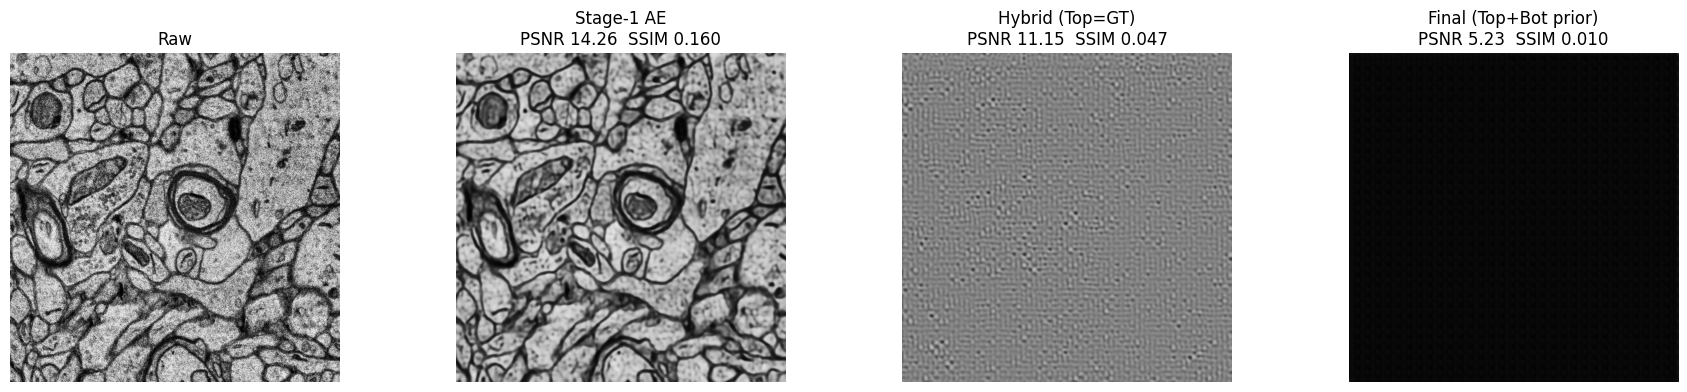

In [17]:
# ============================================================
# Stage-2 推理：AE / Hybrid(Top=GT) / Final(Top+Bot prior)
# —— 完整版（含所有 helper；自动修正输入形状）
# 依赖：已训练好的 Stage-1 `model` 在内存中
# ============================================================

import os, glob, numpy as np, tensorflow as tf, matplotlib.pyplot as plt

# ==== 可选：prior 权重路径（若内存里已有 top_prior/bot_prior 可忽略）====
TOP_W = globals().get('TOP_W', "/content/drive/MyDrive/vqvae_priors_fixed/XXXX/top_best_by_valacc.weights.h5")
BOT_W = globals().get('BOT_W', "/content/drive/MyDrive/vqvae_priors_fixed/XXXX/bottom_best_by_vloss.weights.h5")

# ==== 路径 ====
TEST_DIR  = "/content/drive/MyDrive/h01_cutouts_4nm_test"
SAVE_DIR  = "/content/drive/MyDrive/vqvae_stage2_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# ==== 与训练保持一致的栅格/词表大小 ====
TOP_GRID = int(globals().get('TOP_GRID', 32))
BOT_GRID = int(globals().get('BOTTOM_GRID', 64))
IMAGE_SIZE = int(globals().get('IMAGE_SIZE', 1024))

# 从 Stage-1 码本推断 K（更稳）
K_TOP = int(model.vq_top.embeddings.shape[1])
K_BOT = int(model.vq_bottom.embeddings.shape[1])
TOP_BOS_ID = K_TOP         # 顶层 BOS
BOT_PAD_ID = K_BOT         # 底层 PAD

# 是否用蛇形顺序（训练时若开了，这里也要开）
USE_SERPENTINE_BOTTOM = bool(globals().get('USE_SERPENTINE_BOTTOM', False))

# ==== 若 prior 不在内存，则构建并加载（用你训练时的 build_*）====
if 'build_top_prior' in globals() and 'top_prior' not in globals():
    top_prior = build_top_prior()
    if TOP_W and os.path.exists(TOP_W):
        top_prior.load_weights(TOP_W)

if 'build_bottom_prior_windowed' in globals() and 'bot_prior' not in globals():
    bot_prior = build_bottom_prior_windowed()
    if BOT_W and os.path.exists(BOT_W):
        bot_prior.load_weights(BOT_W)

# -----------------------------
# Helper 1) tokenization（兼容 GPU）
# -----------------------------
@tf.function
def quant_indices_4d(pre_vq_feats, vq_layer):
    shp  = tf.shape(pre_vq_feats)
    flat = tf.reshape(pre_vq_feats, [-1, vq_layer.embedding_dim])
    dists = (tf.reduce_sum(flat**2, axis=1, keepdims=True)
             - 2.0 * tf.matmul(flat, vq_layer.embeddings)
             + tf.reduce_sum(vq_layer.embeddings**2, axis=0, keepdims=True))
    idx = tf.argmax(-dists, axis=1, output_type=tf.int32)
    return tf.reshape(idx, [shp[0], shp[1], shp[2]])

@tf.function
def encode_to_tokens_on_gpu(x):
    with tf.device('/GPU:0'):
        hb = model.enc_bottom(x, training=False)
        zb = model.pre_vq_bottom(hb, training=False)
        idx_b = quant_indices_4d(zb, model.vq_bottom)   # [B,64,64]

        ht = model.enc_top(hb, training=False)
        zt = model.pre_vq_top(ht, training=False)
        idx_t = quant_indices_4d(zt, model.vq_top)      # [B,32,32]
    return idx_t, idx_b

# -----------------------------
# Helper 2) flatten/unflatten（支持蛇形）
# -----------------------------
def flatten_raster(toks_2d):          # tf.Tensor [B,H,W] -> [B,H*W]
    shp = tf.shape(toks_2d)
    return tf.reshape(toks_2d, [shp[0], shp[1]*shp[2]])

def flatten_bottom(idx_b):            # [B,64,64] -> [B,4096]
    if not USE_SERPENTINE_BOTTOM:
        return flatten_raster(idx_b)
    # 逐样本 python 实现（batch 不大时足够）
    arr = idx_b.numpy()
    B,H,W = arr.shape
    out = np.empty((B, H*W), dtype=np.int32)
    for b in range(B):
        seq = []
        for r in range(H):
            row = arr[b, r]
            if r % 2 == 1:
                row = row[::-1]
            seq.append(row)
        out[b] = np.concatenate(seq, axis=0)
    return tf.convert_to_tensor(out, tf.int32)

def unflatten_bottom_to_grid(seq_1d): # [B,4096] -> [B,64,64]
    B = int(seq_1d.shape[0])
    H = BOT_GRID; W = BOT_GRID
    seq = seq_1d.numpy()
    out = np.empty((B,H,W), dtype=np.int32)
    for b in range(B):
        if not USE_SERPENTINE_BOTTOM:
            out[b] = seq[b].reshape(H, W)
        else:
            p = 0
            for r in range(H):
                row = seq[b, p:p+W]
                p += W
                if r % 2 == 1:
                    row = row[::-1]
                out[b, r] = row
    return tf.convert_to_tensor(out, tf.int32)

# -----------------------------
# Helper 3) 解码：tokens -> 图像（用 Stage-1 的模块）
# -----------------------------
def decode_from_indices(idx_t, idx_b):
    # idx_t: [B,32,32]  idx_b: [B,64,64]  (int32)
    emb_t = tf.transpose(model.vq_top.embeddings, [1,0])    # [K,Ct]
    ztq   = tf.gather(emb_t, idx_t)                         # [B,32,32,Ct]
    ztq   = model.post_vq_top(ztq, training=False)          # [B,32,32,Ht]
    t_up  = model.top_up(ztq, training=False)               # [B,64,64,Hb]

    emb_b = tf.transpose(model.vq_bottom.embeddings, [1,0]) # [K,Cb]
    zbq   = tf.gather(emb_b, idx_b)                         # [B,64,64,Cb]
    zbq   = model.post_vq_bottom(zbq, training=False)       # [B,64,64,Hb]

    zbq   = model.norm_b(zbq, training=False)
    t_up  = model.norm_t(t_up, training=False)
    gamma = model.film_gamma(t_up, training=False)
    beta  = model.film_beta(t_up,  training=False)
    zbq_mod = zbq * (1.0 + gamma) + beta

    fused = tf.concat([zbq_mod, t_up], axis=-1)
    y = model.dec_bottom(fused, training=False)             # [B,1024,1024,1]
    return y

# -----------------------------
# Helper 4) 贪心采样（自动补 batch 维）
# -----------------------------
def sample_top_prior_greedy(top_prior, temperature=1.0):
    Lt = TOP_GRID*TOP_GRID
    x_in = np.full((1, Lt), TOP_BOS_ID, dtype=np.int32)   # 先全 BOS，反正有因果遮罩
    out  = np.zeros((1, Lt), dtype=np.int32)
    for t in range(Lt):
        logits = top_prior(x_in, training=False).numpy()  # [1,Lt,K]
        logit_t = logits[0, t] / max(1e-8, float(temperature))
        out[0, t] = int(np.argmax(logit_t))
        if t+1 < Lt:
            x_in[0, t+1] = out[0, t]
    return out  # [1,Lt]（不含 BOS，模型输出空间是 0..K_TOP-1）

def sample_bottom_prior_windowed_greedy(bot_prior, top_seq, temperature=1.0):
    # top_seq: [Lt] 或 [1,Lt]，都可以
    Lt = TOP_GRID*TOP_GRID
    Lb = BOT_GRID*BOT_GRID
    W  = int(globals().get('WINDOW_BOT', 512))
    if isinstance(top_seq, tf.Tensor): top_seq = top_seq.numpy()
    top_seq = top_seq.reshape(1, Lt) if top_seq.ndim == 1 else top_seq  # (1,Lt)

    x_win = np.full((1, W-1), BOT_PAD_ID, dtype=np.int32)
    out   = np.zeros((1, Lb), dtype=np.int32)
    for t in range(Lb):
        logits = bot_prior({"x": x_win, "mem": top_seq}, training=False).numpy()  # [1,W-1,K]
        logit_last = logits[0, -1] / max(1e-8, float(temperature))
        out[0, t] = int(np.argmax(logit_last))
        # slide window
        x_win[:, :-1] = x_win[:, 1:]
        x_win[:, -1]  = out[0, t]
    return out  # [1,Lb]

# -----------------------------
# Helper 5) 读图 / 指标 / 可视化
# -----------------------------
# --- 修正 1：更稳的 resize（常量而非字符串） ---
def load_gray_01(path):
    s = tf.io.read_file(path)
    x = tf.image.decode_png(s, channels=1)                 # [H,W,1], uint8
    x = tf.image.convert_image_dtype(x, tf.float32)        # [0,1]
    x = tf.image.resize(x, [IMAGE_SIZE, IMAGE_SIZE],
                        method=tf.image.ResizeMethod.LANCZOS3)
    return tf.clip_by_value(x, 0.0, 1.0)                   # [H,W,1], float32


# --- 修正 2：把 2D/3D 图像统一成 NHWC 再算指标 ---
def _as_nhwc01(arr):
    t = tf.convert_to_tensor(arr, tf.float32)
    if t.shape.rank == 2:           # [H,W] -> [1,H,W,1]
        t = t[tf.newaxis, ..., tf.newaxis]
    elif t.shape.rank == 3:         # [H,W,1] or [H,W,C] -> [1,H,W,C]
        t = t[tf.newaxis, ...]
    # 若已是 [B,H,W,C] 就不动
    return t

def psnr01(a01, b01):
    a = _as_nhwc01(a01)
    b = _as_nhwc01(b01)
    return float(tf.reduce_mean(tf.image.psnr(a, b, max_val=1.0)).numpy())

def ssim01(a01, b01):
    a = _as_nhwc01(a01)
    b = _as_nhwc01(b01)
    return float(tf.reduce_mean(tf.image.ssim(a, b, max_val=1.0)).numpy())

# ============================================================
# 读取 test 第一张并做三种重组
# ============================================================
paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
assert len(paths) > 0, f"TEST_DIR 为空: {TEST_DIR}"
p0 = paths[0]

# 输入准备
x01 = load_gray_01(p0)                       # [H,W,1] in [0,1]
x   = (x01 - 0.5)[tf.newaxis, ...]           # [1,H,W,1] in [-0.5,0.5]

# 1) Stage-1 AE
y_ae = model(x, training=False)              # [-0.5,0.5]

# 2) Hybrid：Top=GT，Bottom by prior
idx_t_gt, _ = encode_to_tokens_on_gpu(x)     # [1,32,32]
top_seq_gt  = tf.reshape(idx_t_gt, [1, -1])  # [1,1024]
bot_seq_pred = sample_bottom_prior_windowed_greedy(bot_prior, top_seq_gt, temperature=1.0)  # <-- 批维已处理
idx_b_pred   = unflatten_bottom_to_grid(tf.convert_to_tensor(bot_seq_pred, tf.int32))        # [1,64,64]
y_hybrid     = decode_from_indices(idx_t_gt, idx_b_pred)

# 3) Final：Top+Bottom 都由 prior
top_seq_pred = sample_top_prior_greedy(top_prior, temperature=1.0)     # [1,1024]（模型输出空间即真实 token）
idx_t_pred   = tf.reshape(tf.convert_to_tensor(top_seq_pred, tf.int32),
                          [1, TOP_GRID, TOP_GRID])                      # [1,32,32]
bot_seq_pred2= sample_bottom_prior_windowed_greedy(bot_prior, top_seq_pred, temperature=1.0) # [1,4096]
idx_b_pred2  = unflatten_bottom_to_grid(tf.convert_to_tensor(bot_seq_pred2, tf.int32))       # [1,64,64]
y_final      = decode_from_indices(idx_t_pred, idx_b_pred2)

# 指标
raw01   = x01.numpy()[...,0]
ae01    = to01_from_m05(y_ae.numpy()[0,...,0])
hyb01   = to01_from_m05(y_hybrid.numpy()[0,...,0])
final01 = to01_from_m05(y_final.numpy()[0,...,0])

m = lambda a,b: (psnr01(a,b), ssim01(a,b))
psnr_ae, ssim_ae       = m(raw01, ae01)
psnr_hyb, ssim_hyb     = m(raw01, hyb01)
psnr_final, ssim_final = m(raw01, final01)

# 可视化保存
plt.figure(figsize=(18,4))
for i,(im,title) in enumerate([
    (raw01,   "Raw"),
    (ae01,    f"Stage-1 AE\nPSNR {psnr_ae:.2f}  SSIM {ssim_ae:.3f}"),
    (hyb01,   f"Hybrid (Top=GT)\nPSNR {psnr_hyb:.2f}  SSIM {ssim_hyb:.3f}"),
    (final01, f"Final (Top+Bot prior)\nPSNR {psnr_final:.2f}  SSIM {ssim_final:.3f}"),
]):
    ax = plt.subplot(1,4,i+1)
    ax.imshow(im, cmap='gray', vmin=0, vmax=1); ax.set_title(title); ax.axis('off')
plt.tight_layout()
out_path = os.path.join(SAVE_DIR, "panel_test_first.png")
plt.savefig(out_path, dpi=200)
print("✅ Saved:", out_path)


In [ ]:
# ==========================================
# HYBRID (Top=GT, Bottom=prior) — videos + compression
# ==========================================
import os, glob, math, time, json
import numpy as np
import tensorflow as tf
import imageio.v2 as imageio

# -------- Paths --------
TEST_DIR = "/content/drive/MyDrive/h01_cutouts_4nm_test"
TS = time.strftime("%Y%m%d-%H%M%S")
OUT_DIR = f"/content/drive/MyDrive/vqvae_eval_hybrid/{TS}"
os.makedirs(OUT_DIR, exist_ok=True)
video_dir = os.path.join(OUT_DIR, "videos"); os.makedirs(video_dir, exist_ok=True)

# -------- Assert in-memory models --------
for name in ["model", "top_prior", "bot_prior"]:
    assert name in globals(), f"`{name}` not found in memory."
model.trainable = False

# -------- Hyperparams (read from globals) --------
IMAGE_SIZE = int(globals().get('IMAGE_SIZE', 1024))
TOP_GRID   = int(globals().get('TOP_GRID', 32))
BOT_GRID   = int(globals().get('BOTTOM_GRID', 64))
NUM_EMBEDDINGS_TOP    = int(globals().get('NUM_EMBEDDINGS_TOP', 256))
NUM_EMBEDDINGS_BOTTOM = int(globals().get('NUM_EMBEDDINGS_BOTTOM', 256))
WINDOW_BOT = int(globals().get('WINDOW_BOT', 512))  # bottom prior window

# -------- Loader (same as training) --------
def load_gray_1024(path, background='white'):
    s = tf.io.read_file(path)
    x = tf.image.decode_png(s, channels=0)
    x = tf.cast(x, tf.float32)/255.0
    c = tf.shape(x)[-1]
    def to_gray_from_rgb(rgb): return tf.image.rgb_to_grayscale(rgb)
    def handle_rgba(rgba):
        rgb, a = rgba[..., :3], rgba[..., -1:]
        bg = tf.ones_like(rgb) if background == 'white' else tf.zeros_like(rgb)
        return to_gray_from_rgb(rgb * a + bg * (1.0 - a))
    gray = tf.case(
        [(tf.equal(c,1), lambda: x),
         (tf.equal(c,2), lambda: x[..., :1]),
         (tf.equal(c,3), lambda: to_gray_from_rgb(x)),
         (tf.equal(c,4), lambda: handle_rgba(x))],
        default=lambda: to_gray_from_rgb(x[..., :3]),
        exclusive=True)
    gray = tf.image.resize(gray, [IMAGE_SIZE, IMAGE_SIZE], method='bicubic', antialias=True)
    return gray - 0.5  # [-0.5,0.5]

# -------- Stage-1 tokenization & decode --------
@tf.function
def quant_indices_4d(pre_vq_feats, vq_layer):
    shp  = tf.shape(pre_vq_feats)
    flat = tf.reshape(pre_vq_feats, [-1, vq_layer.embedding_dim])
    dists = (tf.reduce_sum(flat**2, axis=1, keepdims=True)
             - 2.0 * tf.matmul(flat, vq_layer.embeddings)
             + tf.reduce_sum(vq_layer.embeddings**2, axis=0, keepdims=True))
    idx = tf.argmax(-dists, axis=1, output_type=tf.int32)
    return tf.reshape(idx, [shp[0], shp[1], shp[2]])

def encode_tokens(x1):  # x1: [1,1024,1024,1]
    hb = model.enc_bottom(x1, training=False)
    zb = model.pre_vq_bottom(hb, training=False)
    idx_b = quant_indices_4d(zb, model.vq_bottom)
    ht = model.enc_top(hb, training=False)
    zt = model.pre_vq_top(ht, training=False)
    idx_t = quant_indices_4d(zt, model.vq_top)
    return idx_t, idx_b

def decode_from_indices(idx_t, idx_b):
    emb_t = tf.transpose(model.vq_top.embeddings, [1,0])    # [K, Ct]
    ztq   = tf.gather(emb_t, idx_t)                         # [1,32,32,Ct]
    ztq   = model.post_vq_top(ztq, training=False)          # [1,32,32,Ht]
    t_up  = model.top_up(ztq, training=False)               # [1,64,64,Hb]

    emb_b = tf.transpose(model.vq_bottom.embeddings, [1,0]) # [K, Cb]
    zbq   = tf.gather(emb_b, idx_b)                         # [1,64,64,Cb]
    zbq   = model.post_vq_bottom(zbq, training=False)       # [1,64,64,Hb]

    zbq   = model.norm_b(zbq, training=False)
    t_up  = model.norm_t(t_up, training=False)
    gamma = model.film_gamma(t_up, training=False)
    beta  = model.film_beta(t_up,  training=False)
    zbq_mod = zbq * (1.0 + gamma) + beta

    fused = tf.concat([zbq_mod, t_up], axis=-1)
    y = model.dec_bottom(fused, training=False)             # [1,1024,1024,1]
    return y

# -------- Bottom prior: Hybrid 小随机采样 --------
def _top_k_filter(logits, k=None):
    if (k is None) or (k <= 0): return logits
    k = min(k, logits.shape[-1])
    thresh = np.partition(logits, -k)[-k]
    logits = np.where(logits < thresh, -1e9, logits)
    return logits

def _top_p_filter(logits, p=None):
    if (p is None) or (p <= 0.0) or (p >= 1.0): return logits
    probs = tf.nn.softmax(logits).numpy()
    idx = np.argsort(-probs)
    cum = np.cumsum(probs[idx])
    mask = cum <= p
    if not np.any(mask):
        mask = np.zeros_like(mask); mask[0] = True  # 至少保留top1
    keep = idx[mask]
    new_logits = np.full_like(logits, -1e9)
    new_logits[keep] = logits[keep]
    return new_logits

def sample_bottom_prior_hybrid(
    top_seq,
    temperature=0.7,   # 低温：更稳
    top_k=64,          # 小范围
    top_p=None,        # 二选一（可改为 0.9）
    eps_greedy=0.05,   # 小概率探索
    rep_window=64,
    rep_penalty=1.05,
    seed=1234
):
    rng = np.random.default_rng(seed)
    Lb = BOT_GRID * BOT_GRID
    W  = WINDOW_BOT
    x_win = np.zeros((1, W-1), dtype=np.int32)
    out = np.zeros((1, Lb), dtype=np.int32)
    mem = top_seq.astype(np.int32)
    recent = []

    for t in range(Lb):
        logits = bot_prior({"x": x_win, "mem": mem}, training=False).numpy()[0, -1]  # [V]

        # 轻度重复惩罚
        if rep_penalty and rep_window > 0 and recent:
            uniq, cnt = np.unique(recent[-rep_window:], return_counts=True)
            logits[uniq] = logits[uniq] - np.log(rep_penalty) * cnt

        # 过滤 + 温度
        logits = _top_k_filter(logits, top_k)
        logits = _top_p_filter(logits, top_p)
        logits = logits / max(1e-8, temperature)

        # ε-greedy
        if rng.random() < eps_greedy:
            probs = tf.nn.softmax(logits).numpy()
            nxt = int(rng.choice(len(probs), p=probs))
        else:
            nxt = int(np.argmax(logits))

        out[0, t] = nxt
        recent.append(nxt)
        x_win = np.roll(x_win, -1, axis=1)
        x_win[0, -1] = nxt
    return out  # [1, Lb]

# -------- Top bits via Top-prior (teacher forcing, bits) --------
def bits_with_priors_top(seq_top):
    x_in  = seq_top[:, :-1]                        # [1, L-1]
    tgt   = seq_top[:, 1:]                         # [1, L-1]
    logits = top_prior(x_in, training=False)       # [1, L-1, V]
    ce_nat = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tgt, logits=logits)  # nats
    bits   = float(tf.reduce_sum(ce_nat).numpy() / math.log(2.0))
    return bits

# -------- PSNR/SSIM（展示重建质量，非必需） --------
def psnr_ssim(a, b):
    a = np.clip(a, 0, 1); b = np.clip(b, 0, 1)
    a_tf = tf.convert_to_tensor(a[None, ..., None], tf.float32)
    b_tf = tf.convert_to_tensor(b[None, ..., None], tf.float32)
    psnr = float(tf.image.psnr(a_tf, b_tf, max_val=1.0)[0].numpy())
    ssim = float(tf.image.ssim(a_tf, b_tf, max_val=1.0)[0].numpy())
    return psnr, ssim


# ---------- Collect test list ----------
all_test_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
assert len(all_test_paths) > 0, f"No PNGs found in {TEST_DIR}"
test_paths = all_test_paths[:30]  # 只用前30张
print(f"Test images (subset): using first {len(test_paths)} of {len(all_test_paths)}")


# -------- Videos (Raw / AE / Hybrid) --------
fps = 8
writers = {
    "raw":     imageio.get_writer(os.path.join(video_dir, "raw.mp4"),         fps=fps),
    "ae":      imageio.get_writer(os.path.join(video_dir, "stage1_ae.mp4"),   fps=fps),
    "hybrid":  imageio.get_writer(os.path.join(video_dir, "hybrid_topGT_bottomPrior.mp4"), fps=fps),
}

# -------- Loop --------
orig_bits_per_image = IMAGE_SIZE*IMAGE_SIZE*8
naive_stage1_bits   = 8 * (TOP_GRID*TOP_GRID + BOT_GRID*BOT_GRID)  # 8b/token baseline

sum_top_bits = 0.0
ps_list_hybrid, ps_list_ae = [], []
ss_list_hybrid, ss_list_ae = [], []

for i, p in enumerate(test_paths):
    # load & raw
    x = load_gray_1024(p)[tf.newaxis, ...]
    raw = (x.numpy()[0, ..., 0] + 0.5)

    # stage-1 AE
    y_ae = model(x, training=False).numpy()[0, ..., 0]
    y_ae = np.clip(y_ae + 0.5, 0, 1)

    # tokens
    idx_t, _ = encode_tokens(x)
    top_seq = tf.reshape(idx_t, [1, TOP_GRID*TOP_GRID]).numpy().astype(np.int32)

    # bottom by prior (hybrid sampling)
    bot_seq_gen = sample_bottom_prior_hybrid(
        top_seq,
        temperature=0.7, top_k=64, top_p=None,
        eps_greedy=0.05, rep_window=64, rep_penalty=1.05, seed=1234+i
    )

    # decode hybrid
    y_hybrid = decode_from_indices(
        tf.reshape(top_seq, [1, TOP_GRID, TOP_GRID]),
        tf.reshape(bot_seq_gen, [1, BOT_GRID, BOT_GRID])
    ).numpy()[0, ..., 0]
    y_hybrid = np.clip(y_hybrid + 0.5, 0, 1)

    # metrics (可选打印均值)
    ps_ae, ss_ae = psnr_ssim(raw, y_ae)
    ps_hy, ss_hy = psnr_ssim(raw, y_hybrid)
    ps_list_ae.append(ps_ae); ss_list_ae.append(ss_ae)
    ps_list_hybrid.append(ps_hy); ss_list_hybrid.append(ss_hy)

    # bits（Hybrid 只传 Top，经先验熵编码）
    top_bits = bits_with_priors_top(top_seq)
    sum_top_bits += top_bits

    # videos
    writers["raw"].append_data((raw*255).astype(np.uint8))
    writers["ae"].append_data((y_ae*255).astype(np.uint8))
    writers["hybrid"].append_data((y_hybrid*255).astype(np.uint8))

# close videos
for w in writers.values():
    w.close()

# -------- Summary numbers --------
N = len(test_paths)
mean_top_bits = sum_top_bits / N
mean_bpp_hybrid = mean_top_bits / (IMAGE_SIZE*IMAGE_SIZE)
mean_ratio_vs_8bit = (orig_bits_per_image / mean_top_bits) if mean_top_bits>0 else float('inf')
naive_bpp = naive_stage1_bits / (IMAGE_SIZE*IMAGE_SIZE)
naive_ratio_vs_8bit = orig_bits_per_image / naive_stage1_bits

summary = {
    "dataset": {"num_images": N, "image_size": IMAGE_SIZE},
    "compression": {
        "hybrid_top_only": {
            "mean_bits_per_image": mean_top_bits,
            "mean_bpp": mean_bpp_hybrid,
            "compression_ratio_vs_8bit": mean_ratio_vs_8bit
        },
        "naive_stage1_8b_per_token": {
            "bits_per_image": naive_stage1_bits,
            "bpp": naive_bpp,
            "compression_ratio_vs_8bit": naive_ratio_vs_8bit
        }
    },
    "quality": {
        "psnr": {"stage1_ae": float(np.mean(ps_list_ae)), "hybrid": float(np.mean(ps_list_hybrid))},
        "ssim": {"stage1_ae": float(np.mean(ss_list_ae)), "hybrid": float(np.mean(ss_list_hybrid))}
    },
    "hybrid_sampling": {"temperature": 0.7, "top_k": 64, "top_p": None, "eps_greedy": 0.05,
                        "rep_window": 64, "rep_penalty": 1.05}
}

with open(os.path.join(OUT_DIR, "metrics_and_bits_hybrid.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n=== HYBRID (Top=GT, Bottom=prior) ===")
print(f"Videos saved under: {video_dir}")
print(json.dumps(summary, indent=2))


In [ ]:
# =========================
# Rate Estimation (NLL->bpp)
# =========================
import numpy as np
import tensorflow as tf
import math, time

PIXELS = IMAGE_SIZE * IMAGE_SIZE

def top_bits_for_seq(top_seq):  # [1, 1024] int32
    # teacher forcing: inp=[:-1], target=[1:]
    x = top_seq[:, :-1]
    y = top_seq[:, 1:]
    logits = top_prior(x, training=False)  # [1,1023,V]
    # 取每步的 -log2 p(target)
    nll = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)  # nat
    bits = tf.reduce_sum(nll) / tf.math.log(tf.constant(2.0))  # nat->bit
    return float(bits.numpy())

def bottom_bits_for_seq(bot_seq, top_seq):  # [1,4096], [1,1024]
    W = WINDOW_BOT
    x_win = np.zeros((1, W-1), dtype=np.int32)
    total_bits = 0.0
    for t in range(bot_seq.shape[1]):
        logits = bot_prior({"x": x_win, "mem": top_seq}, training=False).numpy()  # [1,W-1,V]
        logit_last = logits[0, -1]  # [V]
        # target 是真实 token
        tgt = int(bot_seq[0, t])
        # bits = -log2 p(tgt)
        logp = tf.nn.log_softmax(logit_last)[tgt].numpy()  # nat
        total_bits += float(-logp / math.log(2.0))
        # 滑窗推进
        x_win = np.roll(x_win, -1, axis=1)
        x_win[0, -1] = tgt
    return total_bits

# 估计若干张 test 的平均码率
N_EVAL = min(50, len(test_paths))  # 评 50 张
sum_top_bits = sum_bot_bits = 0.0

for i, p in enumerate(test_paths[:N_EVAL]):
    x = load_gray_1024(p)[tf.newaxis, ...]
    idx_t, idx_b = encode_tokens(x)
    top_seq = tf.reshape(idx_t, [1, TOP_GRID*TOP_GRID]).numpy().astype(np.int32)
    bot_seq = tf.reshape(idx_b, [1, BOTTOM_GRID*BOTTOM_GRID]).numpy().astype(np.int32)

    tb = top_bits_for_seq(top_seq)
    bb = bottom_bits_for_seq(bot_seq, top_seq)
    sum_top_bits += tb
    sum_bot_bits += bb

    if (i+1)%10==0:
        print(f"[{i+1}/{N_EVAL}] top_bits={tb:.1f}, bot_bits={bb:.1f}")

avg_top_bits = sum_top_bits / N_EVAL
avg_bot_bits = sum_bot_bits / N_EVAL
avg_total_bits = avg_top_bits + avg_bot_bits

bpp_stage1_fixed = ( (TOP_GRID*TOP_GRID + BOTTOM_GRID*BOTTOM_GRID) * 8 ) / PIXELS
bpp_priors = avg_total_bits / PIXELS

print("\n==== Compression Numbers ====")
print(f"Stage-1 fixed-rate  : {bpp_stage1_fixed:.5f} bpp  (~{8.0/bpp_stage1_fixed:.1f}×)")
print(f"Stage-1+2 (priors)  : {bpp_priors:.5f} bpp  (~{8.0/bpp_priors:.1f}×)")
print(f"  - Top bits/img    : {avg_top_bits:.1f}")
print(f"  - Bottom bits/img : {avg_bot_bits:.1f}")
print(f"  - Total bits/img  : {avg_total_bits:.1f}")


In [ ]:
# ==========================================
# Make 4 video stacks: raw / stage1 / stage2 / hybrid
# ==========================================
import os, glob, math, time
import numpy as np
import tensorflow as tf
import imageio.v2 as imageio
from PIL import Image

# ---------- paths & options ----------
TEST_DIR = "/content/drive/MyDrive/h01_cutouts_4nm_test"
VIDEO_DIR = "/content/drive/MyDrive/vqvae_eval/videos"
os.makedirs(VIDEO_DIR, exist_ok=True)

FPS = 6
N_FRAMES = None   # None=使用全部测试图片；或设成整数(比如 120)
TEMPERATURE_TOP = 1.0
TEMPERATURE_BOT = 1.0
GREEDY_TOP = True         # True=贪心，确定性快；False=随机采样（更慢但多样）
GREEDY_BOTTOM = True

# ---------- params ----------
assert 'model' in globals(), "Need Stage-1 `model` in memory"
assert 'top_prior' in globals() and 'bot_prior' in globals(), "Need Stage-2 priors loaded"

IMAGE_SIZE       = int(globals().get('IMAGE_SIZE', 1024))
TOP_GRID         = int(globals().get('TOP_GRID', 32))
BOTTOM_GRID      = int(globals().get('BOTTOM_GRID', 64))
NUM_EMBEDDINGS_TOP    = int(globals().get('NUM_EMBEDDINGS_TOP', 256))
NUM_EMBEDDINGS_BOTTOM = int(globals().get('NUM_EMBEDDINGS_BOTTOM', 256))
WINDOW_BOT       = int(globals().get('WINDOW_BOT', 512))

# ---------- load test list ----------
test_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
assert len(test_paths) > 0, f"No PNG files found in {TEST_DIR}"
if N_FRAMES is not None:
    test_paths = test_paths[:int(N_FRAMES)]
print(f"Frames to write: {len(test_paths)}")

# ---------- utils ----------
def to_u8_3ch(x01):
    """x01: [H,W] in [0,1] -> uint8 RGB"""
    fr = np.clip(np.round(x01 * 255.0), 0, 255).astype(np.uint8)
    return np.repeat(fr[..., None], 3, axis=2)

def load_gray_1024(path, background='white'):
    s = tf.io.read_file(path)
    x = tf.image.decode_png(s, channels=0)
    x = tf.cast(x, tf.float32) / 255.0
    c = tf.shape(x)[-1]
    def to_gray_from_rgb(rgb): return tf.image.rgb_to_grayscale(rgb)
    def handle_rgba(rgba):
        rgb, a = rgba[..., :3], rgba[..., -1:]
        bg = tf.ones_like(rgb) if background == 'white' else tf.zeros_like(rgb)
        return to_gray_from_rgb(rgb * a + bg * (1.0 - a))
    gray = tf.case(
        [(tf.equal(c,1), lambda: x),
         (tf.equal(c,2), lambda: x[..., :1]),
         (tf.equal(c,3), lambda: to_gray_from_rgb(x)),
         (tf.equal(c,4), lambda: handle_rgba(x))],
        default=lambda: to_gray_from_rgb(x[..., :3]),
        exclusive=True)
    gray = tf.image.resize(gray, [IMAGE_SIZE, IMAGE_SIZE], method='bicubic', antialias=True)
    return gray - 0.5

@tf.function
def quant_indices_4d(pre_vq_feats, vq_layer):
    shp  = tf.shape(pre_vq_feats)
    flat = tf.reshape(pre_vq_feats, [-1, vq_layer.embedding_dim])
    dists = (tf.reduce_sum(flat**2, axis=1, keepdims=True)
             - 2.0 * tf.matmul(flat, vq_layer.embeddings)
             + tf.reduce_sum(vq_layer.embeddings**2, axis=0, keepdims=True))
    idx = tf.argmax(-dists, axis=1, output_type=tf.int32)
    return tf.reshape(idx, [shp[0], shp[1], shp[2]])

def encode_tokens(x1):
    hb = model.enc_bottom(x1, training=False)
    zb = model.pre_vq_bottom(hb, training=False)
    idx_b = quant_indices_4d(zb, model.vq_bottom)
    ht = model.enc_top(hb, training=False)
    zt = model.pre_vq_top(ht, training=False)
    idx_t = quant_indices_4d(zt, model.vq_top)
    return idx_t, idx_b

def decode_from_indices(idx_t, idx_b):
    emb_t = tf.transpose(model.vq_top.embeddings, [1,0])
    ztq   = tf.gather(emb_t, idx_t)
    ztq   = model.post_vq_top(ztq, training=False)
    t_up  = model.top_up(ztq, training=False)
    emb_b = tf.transpose(model.vq_bottom.embeddings, [1,0])
    zbq   = tf.gather(emb_b, idx_b)
    zbq   = model.post_vq_bottom(zbq, training=False)
    zbq   = model.norm_b(zbq, training=False)
    t_up  = model.norm_t(t_up, training=False)
    gamma = model.film_gamma(t_up, training=False)
    beta  = model.film_beta(t_up,  training=False)
    fused = tf.concat([zbq * (1.0 + gamma) + beta, t_up], axis=-1)
    y = model.dec_bottom(fused, training=False)
    return y

def sample_top_prior(temperature=1.0, greedy=True):
    L = TOP_GRID * TOP_GRID
    seq = np.zeros((1, L), dtype=np.int32)
    x_in = np.zeros((1, L-1), dtype=np.int32)
    for pos in range(L-1):
        if pos >= 0:
            x_in[0, :pos+1] = seq[0, :pos+1]
        logits = top_prior(x_in, training=False).numpy()  # [1,L-1,V]
        logit_t = logits[0, pos] / max(1e-8, temperature)
        if greedy:
            nxt = int(np.argmax(logit_t))
        else:
            p = tf.nn.softmax(logit_t).numpy()
            nxt = int(np.random.choice(len(p), p=p))
        seq[0, pos+1] = nxt
    return seq

def sample_bottom_prior_given_top(top_seq, temperature=1.0, greedy=True):
    Lb = BOTTOM_GRID * BOTTOM_GRID
    W  = WINDOW_BOT
    x_win = np.zeros((1, W-1), dtype=np.int32)
    out = np.zeros((1, Lb), dtype=np.int32)
    mem = top_seq.astype(np.int32)
    for t in range(Lb):
        logits = bot_prior({"x": x_win, "mem": mem}, training=False).numpy()  # [1,W-1,V]
        logit_last = logits[0, -1] / max(1e-8, temperature)
        if greedy:
            nxt = int(np.argmax(logit_last))
        else:
            p = tf.nn.softmax(logit_last).numpy()
            nxt = int(np.random.choice(len(p), p=p))
        out[0, t] = nxt
        x_win = np.roll(x_win, -1, axis=1)
        x_win[0, -1] = nxt
    return out

# ---------- open 4 writers ----------
raw_path     = os.path.join(VIDEO_DIR, "raw_stack.mp4")
ae_path      = os.path.join(VIDEO_DIR, "stage1_ae_stack.mp4")
prior_path   = os.path.join(VIDEO_DIR, "stage2_only_stack.mp4")
hybrid_path  = os.path.join(VIDEO_DIR, "topgt_bottomprior_stack.mp4")

raw_w     = imageio.get_writer(raw_path, fps=FPS, codec='libx264', quality=8)
ae_w      = imageio.get_writer(ae_path,  fps=FPS, codec='libx264', quality=8)
prior_w   = imageio.get_writer(prior_path, fps=FPS, codec='libx264', quality=8)
hybrid_w  = imageio.get_writer(hybrid_path, fps=FPS, codec='libx264', quality=8)

t0 = time.time()
for i, p in enumerate(test_paths):
    # 1) raw
    x = load_gray_1024(p)[tf.newaxis, ...]          # [-0.5,0.5]
    raw = (x.numpy()[0, ..., 0] + 0.5)              # [0,1]
    raw_w.append_data(to_u8_3ch(raw))

    # 2) stage-1 AE
    y_ae = model(x, training=False).numpy()[0, ..., 0]
    y_ae = np.clip(y_ae + 0.5, 0, 1)
    ae_w.append_data(to_u8_3ch(y_ae))

    # 3) stage-2 only（为避免所有帧相同：可将 GREEDY_* 设为 False 或调高温度）
    top_seq_samp = sample_top_prior(TEMPERATURE_TOP, GREEDY_TOP)
    bot_seq_samp = sample_bottom_prior_given_top(top_seq_samp, TEMPERATURE_BOT, GREEDY_BOTTOM)
    y_prior = decode_from_indices(
        tf.reshape(top_seq_samp, [1, TOP_GRID, TOP_GRID]),
        tf.reshape(bot_seq_samp, [1, BOTTOM_GRID, BOTTOM_GRID])
    ).numpy()[0, ..., 0]
    y_prior = np.clip(y_prior + 0.5, 0, 1)
    prior_w.append_data(to_u8_3ch(y_prior))

    # 4) Top(gt) + Bottom(prior)
    idx_t, _ = encode_tokens(x)
    top_seq = tf.reshape(idx_t, [1, TOP_GRID*TOP_GRID]).numpy().astype(np.int32)
    bot_seq = sample_bottom_prior_given_top(top_seq, TEMPERATURE_BOT, GREEDY_BOTTOM)
    y_hybrid = decode_from_indices(
        tf.reshape(top_seq, [1, TOP_GRID, TOP_GRID]),
        tf.reshape(bot_seq, [1, BOTTOM_GRID, BOTTOM_GRID])
    ).numpy()[0, ..., 0]
    y_hybrid = np.clip(y_hybrid + 0.5, 0, 1)
    hybrid_w.append_data(to_u8_3ch(y_hybrid))

    if (i+1) % 10 == 0:
        dt = time.time() - t0
        print(f"[{i+1}/{len(test_paths)}] wrote frames | {dt:.1f}s")

# ---------- close writers ----------
raw_w.close(); ae_w.close(); prior_w.close(); hybrid_w.close()
print("Saved videos:")
print("  Raw:     ", raw_path)
print("  Stage-1: ", ae_path)
print("  Stage-2: ", prior_path)
print("  Hybrid:  ", hybrid_path)
